<a href="https://colab.research.google.com/github/gbr-git/Masters_Project/blob/main/Customer_Feedback_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install kaggle
! pip install -q kaggle

 # Download kaggle.json file from your kaggle profile and upload
from google.colab import files
files.upload()

# Download yelp dataset from kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d yelp-dataset/yelp-dataset

# UnZip the downloaded data
import zipfile
with zipfile.ZipFile('/content/yelp-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('')

# Remove the ZIP file
import os
os.remove("/content/yelp-dataset.zip")

# Save data to drive
from google.colab import drive
drive.mount('/content/drive')

Saving kaggle.json to kaggle.json
100% 4.07G/4.07G [00:44<00:00, 169MB/s]
100% 4.07G/4.07G [00:44<00:00, 97.7MB/s]
Mounted at /content/drive


In [2]:
!pip install pyspark
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.window import Window

spark = SparkSession.builder.appName('yelp_dataset').getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=28edb8c28aa27262503399e80fc4ff70b23ae8f472c058b6313b0f550b70e354
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [3]:
reviews_sk = spark.read.json('/content/yelp_academic_dataset_review.json')
# We will get a sample of 10L from the dataset
sample_review=reviews_sk.sample(False, 0.1, seed=0).limit(1000000)
reviews_pd = sample_review.select("*").toPandas()

# Overview of the converted sample
reviews_pd.to_csv('yelp_review_sample.csv')
reviews_pd.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,YjUWPpI6HXG530lwP-fb2A,0,2014-02-05 20:30:30,0,saUsX_uimxRlCVr67Z4Jig,3.0,Family diner. Had the buffet. Eclectic assortm...,0,8g_iMtfSiwikVnbP2etR0A
1,gebiRewfieSdtt17PTW6Zg,0,2016-07-25 07:31:06,0,pUycOfUwM8vqX7KjRRhUEA,3.0,Had a party of 6 here for hibachi. Our waitres...,0,59MxRhNVhU9MYndMkz0wtw
2,YtSqYv1Q_pOltsVPSx54SA,0,2013-06-24 11:21:25,0,oyaMhzBSwfGgemSGuZCdwQ,5.0,Tremendous service (Big shout out to Douglas) ...,0,Dd1jQj7S-BFGqRbApFzCFw
3,x4XdNhp0Xn8lOivzc77J-g,0,2013-08-15 15:27:51,0,G_5UczbCBJriUAbxz3J7Tw,5.0,Best thai food in the area. Everything was au...,0,clWLI5OZP2ad25ugMVI8gg
4,j8JOZvfeHEfUWq3gEz6ABQ,0,2014-06-11 14:55:14,3,Ki90-hauSIfW_7sBuBBqfA,2.0,NEVER AGAIN. This is a so called restaurant th...,2,Z2cOL3n9V8NoguJ-uU_Nvw


In [4]:
!cp 'yelp_review_sample.csv' '/content/drive/MyDrive'

# !cp 'yelp_business.csv' '/content/drive/MyDrive'

In [5]:
business_sk=spark.read.json('/content/yelp_academic_dataset_business.json')
business_pd=business_sk.select("*").toPandas()

In [6]:
business_pd.columns

Index(['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'is_open', 'latitude', 'longitude', 'name', 'postal_code',
       'review_count', 'stars', 'state'],
      dtype='object')

In [7]:
# If we look at the categories, all most every store selling food has one of these tags
food_tags=['Food','Restaurants','Cafes']

# Save the dataset
business_pd.to_csv('yelp_business.csv')

In [8]:
# We will add a column serves_food to identify if the store serves food or not
serves_food=[]
for i in range(len(business_pd)):
    try:
        if(business_pd.iloc[i]['categories'] is not None):
            categories=business_pd.iloc[i]['categories'].split(',')
            categories=[en.replace(' ','') for en in categories]
            matched_tags=(list(set(categories).intersection(food_tags)))
            if(len(matched_tags)>0):
                serves_food.append(1)
            else:
                serves_food.append(0)
        else:
            serves_food.append(0)
    except:
        print(business_pd.iloc[i]['categories'])
        serves_food.append(2)

business_pd.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,"1616 Chapala St, Ste 2","(None, None, None, None, None, None, None, Non...",Pns2l4eNsfO8kk83dixA6A,"Doctors, Traditional Chinese Medicine, Naturop...",Santa Barbara,None,0,34.426679,-119.711197,"Abby Rappoport, LAC, CMQ",93101,7,5.0,CA
1,87 Grasso Plaza Shopping Center,"(None, None, None, None, None, None, None, Non...",mpf3x-BjTdTEA3yCZrAYPw,"Shipping Centers, Local Services, Notaries, Ma...",Affton,"(8:0-18:30, 0:0-0:0, 8:0-14:0, None, 8:0-18:30...",1,38.551126,-90.335695,The UPS Store,63123,15,3.0,MO
2,5255 E Broadway Blvd,"(None, None, None, None, None, None, None, Tru...",tUFrWirKiKi_TAnsVWINQQ,"Department Stores, Shopping, Fashion, Home & G...",Tucson,"(8:0-23:0, 8:0-22:0, 8:0-23:0, 8:0-22:0, 8:0-2...",0,32.223236,-110.880452,Target,85711,22,3.5,AZ
3,935 Race St,"(None, None, u'none', None, None, None, None, ...",MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",Philadelphia,"(7:0-21:0, 7:0-20:0, 7:0-21:0, 7:0-21:0, 7:0-2...",1,39.955505,-75.155564,St Honore Pastries,19107,80,4.0,PA
4,101 Walnut St,"(None, None, None, None, None, None, None, Tru...",mWMc6_wTdE0EUBKIGXDVfA,"Brewpubs, Breweries, Food",Green Lane,"(12:0-22:0, None, 12:0-22:0, 12:0-18:0, 16:0-2...",1,40.338183,-75.471659,Perkiomen Valley Brewery,18054,13,4.5,PA


In [9]:
business_pd['serves_food']=serves_food
business_food=business_pd[business_pd['serves_food']==1]
business_food.to_csv('yelp_business_food.csv')

In [10]:
# Copy the dataset to drive
!cp 'yelp_business_food.csv' '/content/drive/MyDrive'

In [11]:
# ids of the food stores
business_food_ids=business_food['business_id']


# From the review dataset we will extract the reviews for food stores
business_food_reviews=reviews_pd[reviews_pd['business_id'].isin(business_food_ids)]
business_food_reviews.to_csv('yelp_business_food_reviews.csv')
business_food_reviews.shape


!cp 'yelp_business_food_reviews.csv' '/content/drive/MyDrive'


# Food store Reviews
business_food_reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,YjUWPpI6HXG530lwP-fb2A,0,2014-02-05 20:30:30,0,saUsX_uimxRlCVr67Z4Jig,3.0,Family diner. Had the buffet. Eclectic assortm...,0,8g_iMtfSiwikVnbP2etR0A
1,gebiRewfieSdtt17PTW6Zg,0,2016-07-25 07:31:06,0,pUycOfUwM8vqX7KjRRhUEA,3.0,Had a party of 6 here for hibachi. Our waitres...,0,59MxRhNVhU9MYndMkz0wtw
2,YtSqYv1Q_pOltsVPSx54SA,0,2013-06-24 11:21:25,0,oyaMhzBSwfGgemSGuZCdwQ,5.0,Tremendous service (Big shout out to Douglas) ...,0,Dd1jQj7S-BFGqRbApFzCFw
3,x4XdNhp0Xn8lOivzc77J-g,0,2013-08-15 15:27:51,0,G_5UczbCBJriUAbxz3J7Tw,5.0,Best thai food in the area. Everything was au...,0,clWLI5OZP2ad25ugMVI8gg
4,j8JOZvfeHEfUWq3gEz6ABQ,0,2014-06-11 14:55:14,3,Ki90-hauSIfW_7sBuBBqfA,2.0,NEVER AGAIN. This is a so called restaurant th...,2,Z2cOL3n9V8NoguJ-uU_Nvw


In [12]:
# Overview of the dataset
print('Number of unique Reviews:',str(len(business_food_reviews)))
print('Number of unique Businesses:',str(len(business_food_reviews.business_id.unique())))
print('Number of unique Users that posted a Review:',str(len(business_food_reviews.user_id.unique())))

Number of unique Reviews: 512481
Number of unique Businesses: 54656
Number of unique Users that posted a Review: 318677


In [13]:
# Merging the store info with review  dataset
review_business_data_merged=pd.merge(business_food_reviews,business_food,how='left',on='business_id')
review_business_data_merged.head()

,business_id,cool,date,funny,review_id,stars_x,text,useful,user_id,address,...,hours,is_open,latitude,longitude,name,postal_code,review_count,stars_y,state,serves_food
0,YjUWPpI6HXG530lwP-fb2A,0,2014-02-05 20:30:30,0,saUsX_uimxRlCVr67Z4Jig,3.0,Family diner. Had the buffet. Eclectic assortm...,0,8g_iMtfSiwikVnbP2etR0A,748 W Starr Pass Blvd,...,None,1,32.207233,-110.980864,Kettle Restaurant,85713,47,3.5,AZ,1
1,gebiRewfieSdtt17PTW6Zg,0,2016-07-25 07:31:06,0,pUycOfUwM8vqX7KjRRhUEA,3.0,Had a party of 6 here for hibachi. Our waitres...,0,59MxRhNVhU9MYndMkz0wtw,502 State St,...,"(None, 0:0-0:0, None, None, None, None, None)",1,34.416984,-119.695556,Hibachi Steak House & Sushi Bar,93101,488,3.5,CA,1
2,YtSqYv1Q_pOltsVPSx54SA,0,2013-06-24 11:21:25,0,oyaMhzBSwfGgemSGuZCdwQ,5.0,Tremendous service (Big shout out to Douglas) ...,0,Dd1jQj7S-BFGqRbApFzCFw,1701 Locust St,...,"(16:30-22:0, None, 16:30-22:0, 16:30-22:0, 16:...",1,39.948949,-75.169532,Rittenhouse Grill,19103,290,3.5,PA,1
3,x4XdNhp0Xn8lOivzc77J-g,0,2013-08-15 15:27:51,0,G_5UczbCBJriUAbxz3J7Tw,5.0,Best thai food in the area. Everything was au...,0,clWLI5OZP2ad25ugMVI8gg,"700 Nutt Rd, Ste 730",...,"(17:0-22:0, None, 17:0-22:0, 17:0-21:0, 17:0-2...",1,40.132635,-75.533226,Thai Place Restaurant,19460,222,4.5,PA,1
4,j8JOZvfeHEfUWq3gEz6ABQ,0,2014-06-11 14:55:14,3,Ki90-hauSIfW_7sBuBBqfA,2.0,NEVER AGAIN. This is a so called restaurant th...,2,Z2cOL3n9V8NoguJ-uU_Nvw,600 Poland Ave,...,"(12:0-23:0, 0:0-0:0, 12:0-23:0, 12:0-23:0, 12:...",1,29.959824,-90.033259,Bacchanal Fine Wine & Spirits,70117,1156,4.5,LA,1


In [14]:
# Copy to dive
review_business_data_merged.to_csv('yelp_reviews_business_merged.csv')
!cp 'yelp_reviews_business_merged.csv' '/content/drive/MyDrive'

In [15]:
# Drop unwanted columns
# review_business_data_merged=review_business_data_merged.drop(columns=['hours','attributes','useful','funny'])
review_business_data_merged.head()

,business_id,cool,date,funny,review_id,stars_x,text,useful,user_id,address,...,hours,is_open,latitude,longitude,name,postal_code,review_count,stars_y,state,serves_food
0,YjUWPpI6HXG530lwP-fb2A,0,2014-02-05 20:30:30,0,saUsX_uimxRlCVr67Z4Jig,3.0,Family diner. Had the buffet. Eclectic assortm...,0,8g_iMtfSiwikVnbP2etR0A,748 W Starr Pass Blvd,...,None,1,32.207233,-110.980864,Kettle Restaurant,85713,47,3.5,AZ,1
1,gebiRewfieSdtt17PTW6Zg,0,2016-07-25 07:31:06,0,pUycOfUwM8vqX7KjRRhUEA,3.0,Had a party of 6 here for hibachi. Our waitres...,0,59MxRhNVhU9MYndMkz0wtw,502 State St,...,"(None, 0:0-0:0, None, None, None, None, None)",1,34.416984,-119.695556,Hibachi Steak House & Sushi Bar,93101,488,3.5,CA,1
2,YtSqYv1Q_pOltsVPSx54SA,0,2013-06-24 11:21:25,0,oyaMhzBSwfGgemSGuZCdwQ,5.0,Tremendous service (Big shout out to Douglas) ...,0,Dd1jQj7S-BFGqRbApFzCFw,1701 Locust St,...,"(16:30-22:0, None, 16:30-22:0, 16:30-22:0, 16:...",1,39.948949,-75.169532,Rittenhouse Grill,19103,290,3.5,PA,1
3,x4XdNhp0Xn8lOivzc77J-g,0,2013-08-15 15:27:51,0,G_5UczbCBJriUAbxz3J7Tw,5.0,Best thai food in the area. Everything was au...,0,clWLI5OZP2ad25ugMVI8gg,"700 Nutt Rd, Ste 730",...,"(17:0-22:0, None, 17:0-22:0, 17:0-21:0, 17:0-2...",1,40.132635,-75.533226,Thai Place Restaurant,19460,222,4.5,PA,1
4,j8JOZvfeHEfUWq3gEz6ABQ,0,2014-06-11 14:55:14,3,Ki90-hauSIfW_7sBuBBqfA,2.0,NEVER AGAIN. This is a so called restaurant th...,2,Z2cOL3n9V8NoguJ-uU_Nvw,600 Poland Ave,...,"(12:0-23:0, 0:0-0:0, 12:0-23:0, 12:0-23:0, 12:...",1,29.959824,-90.033259,Bacchanal Fine Wine & Spirits,70117,1156,4.5,LA,1


In [16]:
review_business_data_merged=pd.read_csv('/content/drive/MyDrive/yelp_reviews_business_merged.csv')
review_business_data_merged=review_business_data_merged.drop(columns=['Unnamed: 0'])

# CREATING A NEW COLUMN IN THE DATASET FOR THE NUMBER OF WORDS IN THE REVIEW
review_business_data_merged['length(No of words count in Text)'] = review_business_data_merged['text'].apply(len)
review_business_data_merged.head()
# SHAPE OF THE DATASET
print("Shape of the dataset:")
print(review_business_data_merged.shape)
# COLUMN NAMES
print("Column names:")
print(review_business_data_merged.columns)
# DATATYPE OF EACH COLUMN
print("Datatype of each column:")
print(review_business_data_merged.dtypes)
# DATASET SUMMARY
review_business_data_merged[['cool', 'funny', 'stars_x', 'useful', 'latitude', 'longitude', 'review_count', 'length(No of words count in Text)']].describe()

Shape of the dataset:
(512481, 24)
Column names:
Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars_x', 'text',
       'useful', 'user_id', 'address', 'attributes', 'categories', 'city',
       'hours', 'is_open', 'latitude', 'longitude', 'name', 'postal_code',
       'review_count', 'stars_y', 'state', 'serves_food',
       'length(No of words count in Text)'],
      dtype='object')
Datatype of each column:
business_id                           object
cool                                   int64
date                                  object
funny                                  int64
review_id                             object
stars_x                              float64
text                                  object
useful                                 int64
user_id                               object
address                               object
attributes                            object
categories                            object
city                            

,cool,funny,stars_x,useful,latitude,longitude,review_count,length(No of words count in Text)
count,512481.000000,512481.000000,512481.000000,512481.000000,512481.000000,512481.000000,512481.000000,512481.000000
mean,0.502325,0.313167,3.804943,1.015965,35.894595,-89.140159,467.169823,543.212275
std,2.280268,1.736547,1.391277,2.925837,5.353948,14.391047,827.385167,500.754881
min,0.000000,0.000000,1.000000,0.000000,27.564457,-120.083748,5.000000,1.000000
25%,0.000000,0.000000,3.000000,0.000000,29.960266,-90.242902,80.000000,218.000000
50%,0.000000,0.000000,4.000000,0.000000,38.601144,-86.159694,204.000000,388.000000
75%,0.000000,0.000000,5.000000,1.000000,39.943781,-75.456700,480.000000,692.000000
max,399.000000,353.000000,5.000000,399.000000,53.649743,-74.661348,7568.000000,5000.000000


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

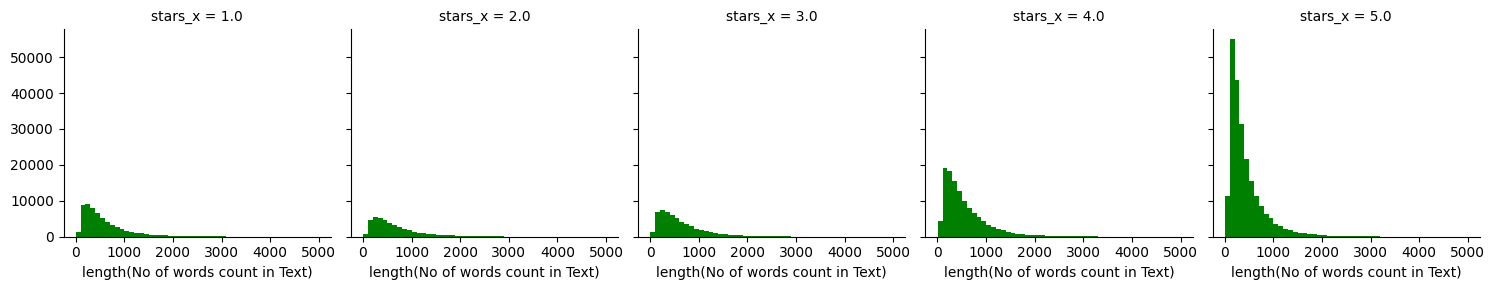

In [18]:
# COMPARING TEXT LENGTH TO STARS
graph = sns.FacetGrid(data=review_business_data_merged, col='stars_x')
graph.map(plt.hist, 'length(No of words count in Text)', bins=50, color='green')

In [19]:
# GETTING THE MEAN VALUES OF THE VOTE COLUMNS WRT THE STARS ON THE REVIEW
stval = review_business_data_merged.groupby('stars_x').mean()
stval
# FINDING THE CORRELATION BETWEEN THE VOTE COLUMNS
stval.corr()
stval[['cool', 'funny', 'useful', 'length(No of words count in Text)']].corr()

<ipython-input-19-3499c65eec71>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stval = review_business_data_merged.groupby('stars_x').mean()


,cool,funny,useful,length(No of words count in Text)
cool,1.000000,-0.662784,-0.322872,-0.551911
funny,-0.662784,1.000000,0.904619,0.913326
useful,-0.322872,0.904619,1.000000,0.833347
length(No of words count in Text),-0.551911,0.913326,0.833347,1.000000


<Axes: xlabel='stars_x', ylabel='length(No of words count in Text)'>

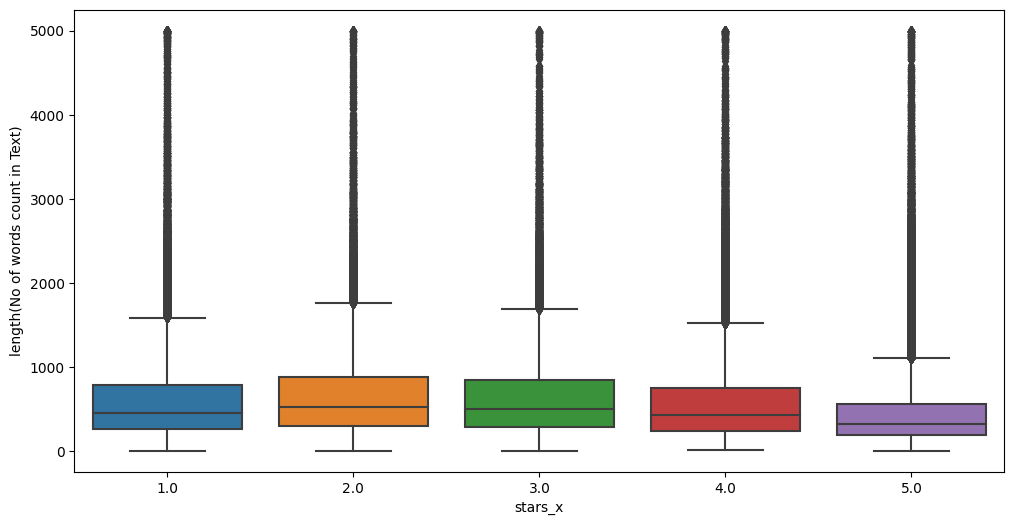

In [20]:
plt.figure(figsize=(12,6))
sns.boxplot(x=review_business_data_merged['stars_x'],y=review_business_data_merged['length(No of words count in Text)'])

<Axes: xlabel='stars_x', ylabel='count'>

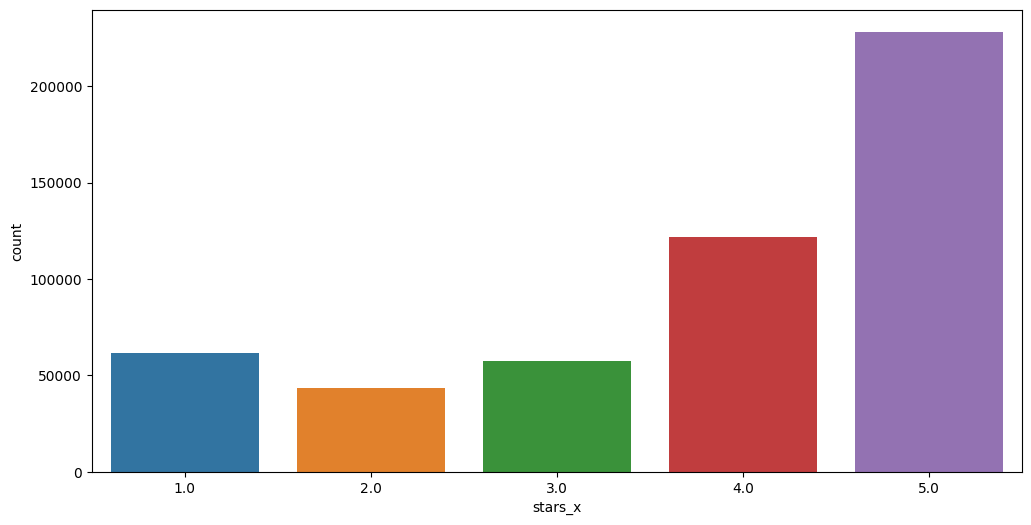

In [21]:
plt.figure(figsize=(12,6))
sns.countplot(x=review_business_data_merged['stars_x'])

In [22]:
review_business_data_merged.head()

,business_id,cool,date,funny,review_id,stars_x,text,useful,user_id,address,...,is_open,latitude,longitude,name,postal_code,review_count,stars_y,state,serves_food,length(No of words count in Text)
0,YjUWPpI6HXG530lwP-fb2A,0,2014-02-05 20:30:30,0,saUsX_uimxRlCVr67Z4Jig,3.0,Family diner. Had the buffet. Eclectic assortm...,0,8g_iMtfSiwikVnbP2etR0A,748 W Starr Pass Blvd,...,1,32.207233,-110.980864,Kettle Restaurant,85713,47,3.5,AZ,1,339
1,gebiRewfieSdtt17PTW6Zg,0,2016-07-25 07:31:06,0,pUycOfUwM8vqX7KjRRhUEA,3.0,Had a party of 6 here for hibachi. Our waitres...,0,59MxRhNVhU9MYndMkz0wtw,502 State St,...,1,34.416984,-119.695556,Hibachi Steak House & Sushi Bar,93101,488,3.5,CA,1,524
2,YtSqYv1Q_pOltsVPSx54SA,0,2013-06-24 11:21:25,0,oyaMhzBSwfGgemSGuZCdwQ,5.0,Tremendous service (Big shout out to Douglas) ...,0,Dd1jQj7S-BFGqRbApFzCFw,1701 Locust St,...,1,39.948949,-75.169532,Rittenhouse Grill,19103,290,3.5,PA,1,276
3,x4XdNhp0Xn8lOivzc77J-g,0,2013-08-15 15:27:51,0,G_5UczbCBJriUAbxz3J7Tw,5.0,Best thai food in the area. Everything was au...,0,clWLI5OZP2ad25ugMVI8gg,"700 Nutt Rd, Ste 730",...,1,40.132635,-75.533226,Thai Place Restaurant,19460,222,4.5,PA,1,110
4,j8JOZvfeHEfUWq3gEz6ABQ,0,2014-06-11 14:55:14,3,Ki90-hauSIfW_7sBuBBqfA,2.0,NEVER AGAIN. This is a so called restaurant th...,2,Z2cOL3n9V8NoguJ-uU_Nvw,600 Poland Ave,...,1,29.959824,-90.033259,Bacchanal Fine Wine & Spirits,70117,1156,4.5,LA,1,590


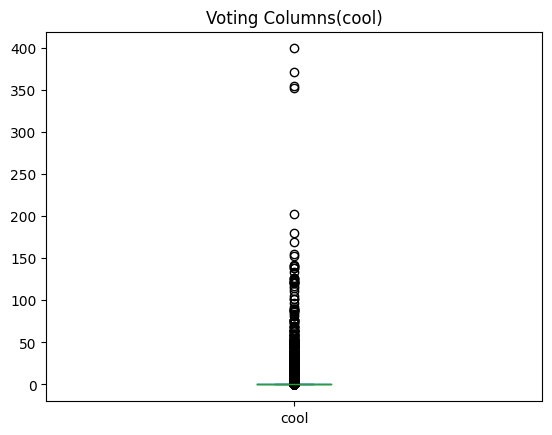

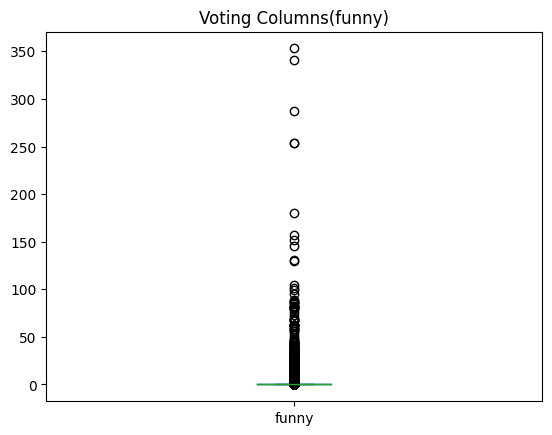

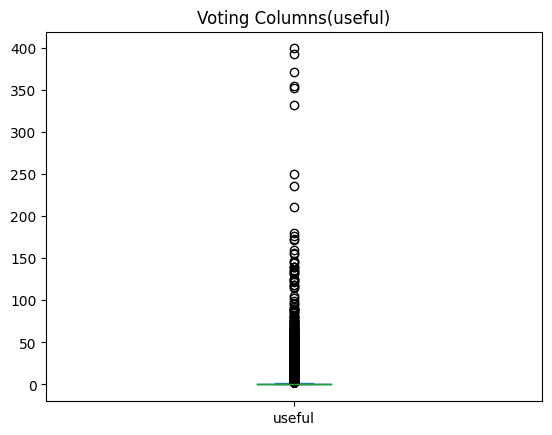

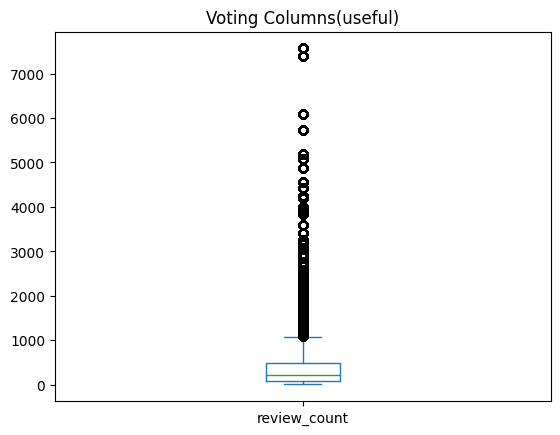

In [23]:
review_business_data_merged['cool'].plot(kind='box', title='Voting Columns(cool)')
plt.show()
review_business_data_merged['funny'].plot(kind='box', title='Voting Columns(funny)')
plt.show()
review_business_data_merged['useful'].plot(kind='box', title='Voting Columns(useful)')
plt.show()
review_business_data_merged['review_count'].plot(kind='box', title='Voting Columns(useful)')
plt.show()

<Axes: xlabel='cool', ylabel='length(No of words count in Text)'>

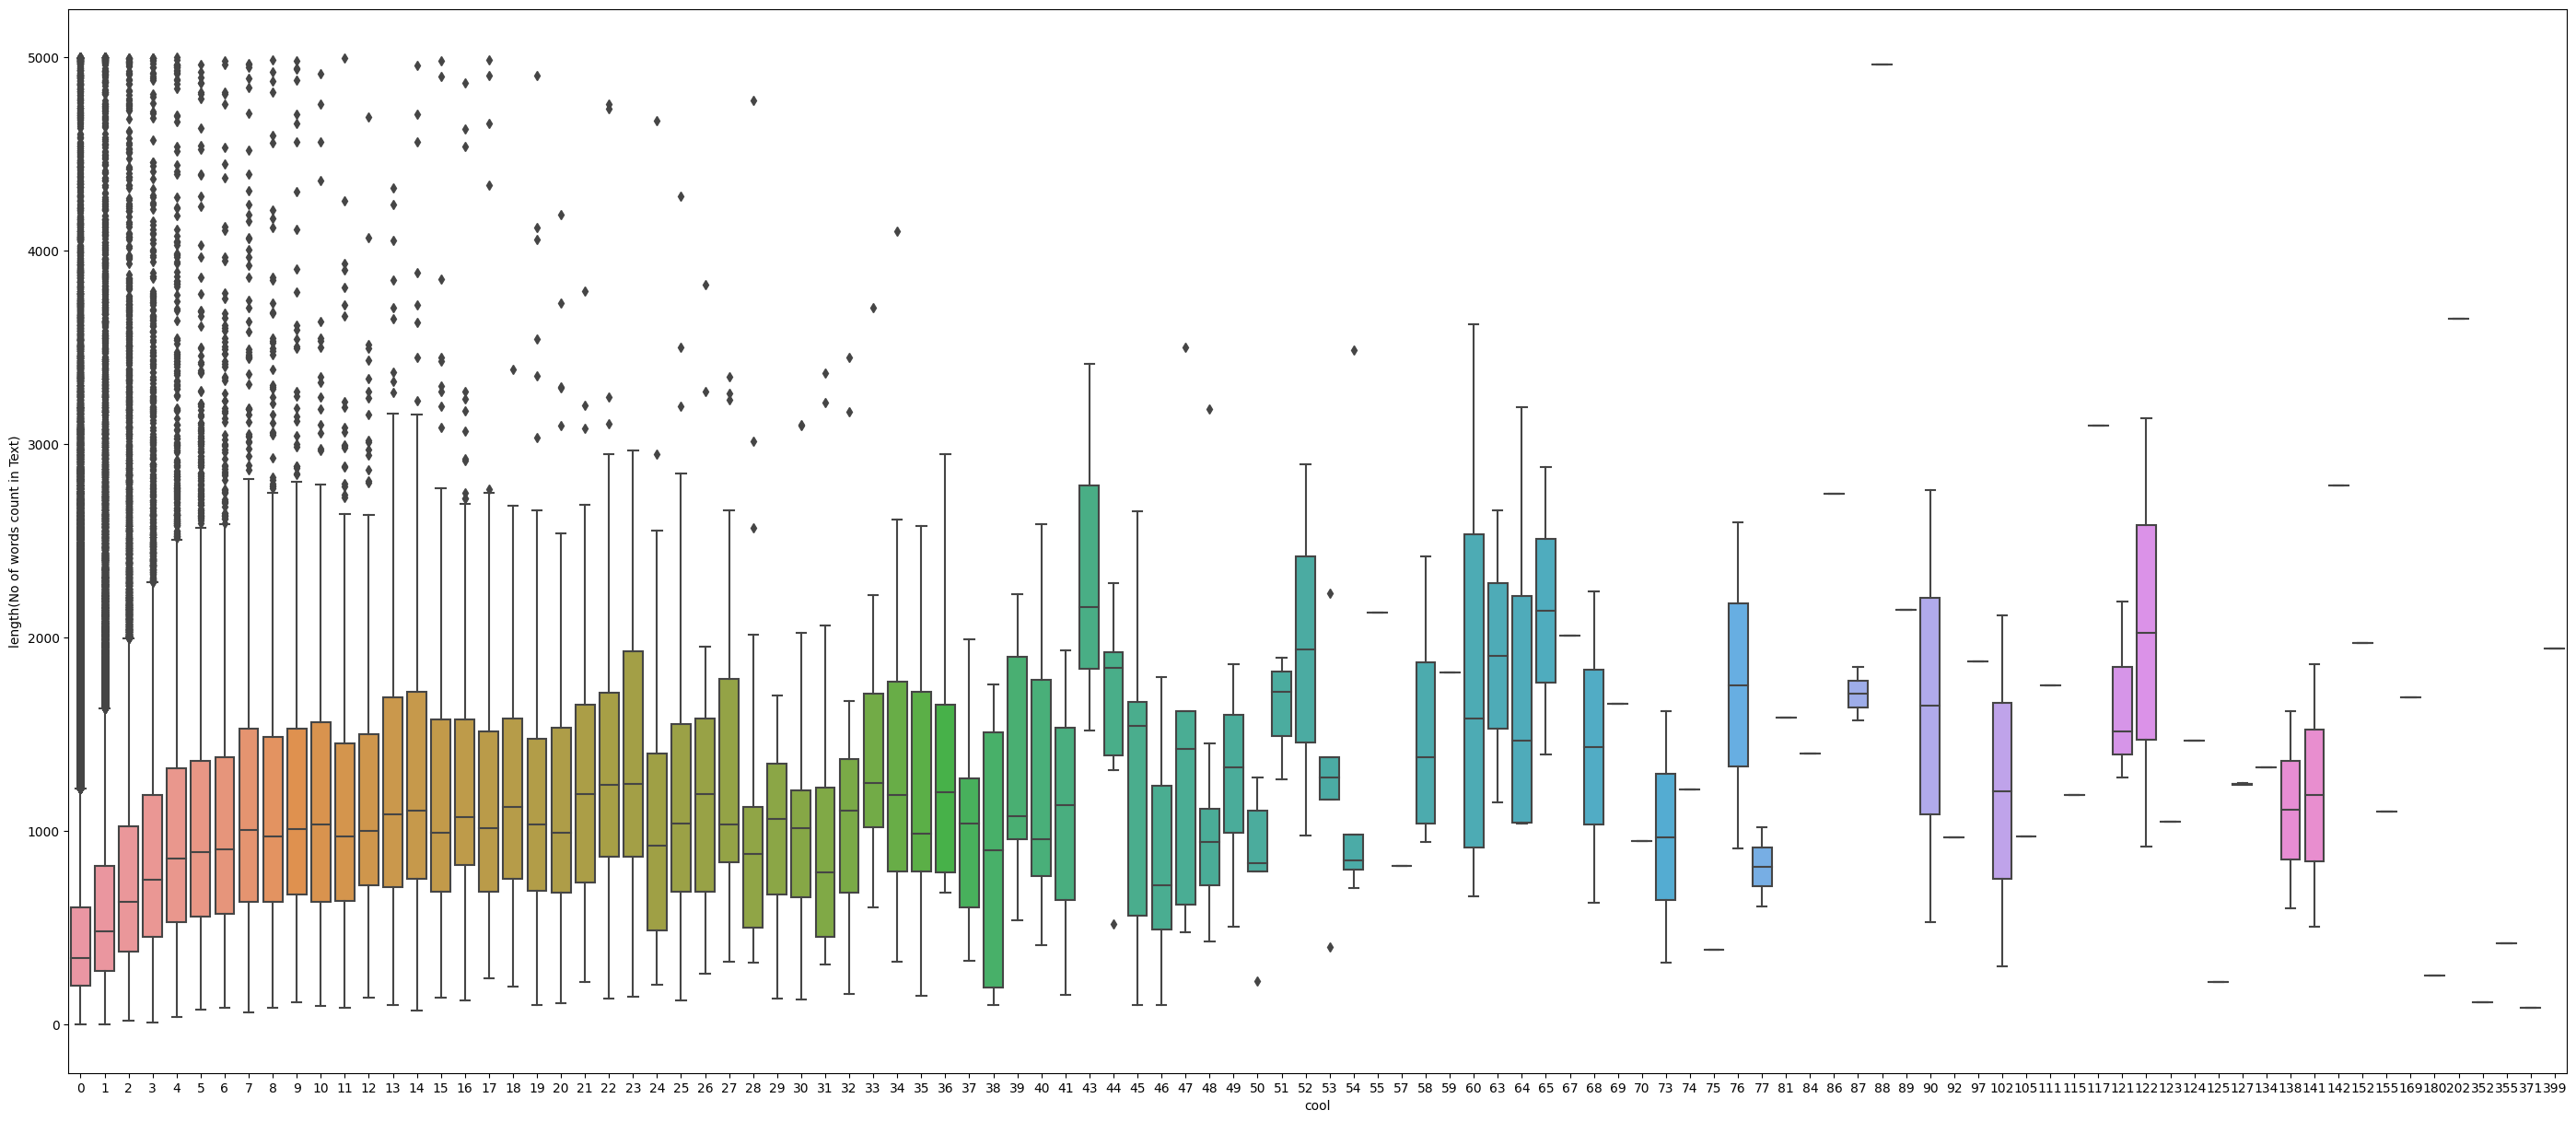

In [24]:
plt.figure(figsize=(35,15))
sns.boxplot(x=review_business_data_merged['cool'],y=review_business_data_merged['length(No of words count in Text)'])

<Axes: xlabel='funny', ylabel='length(No of words count in Text)'>

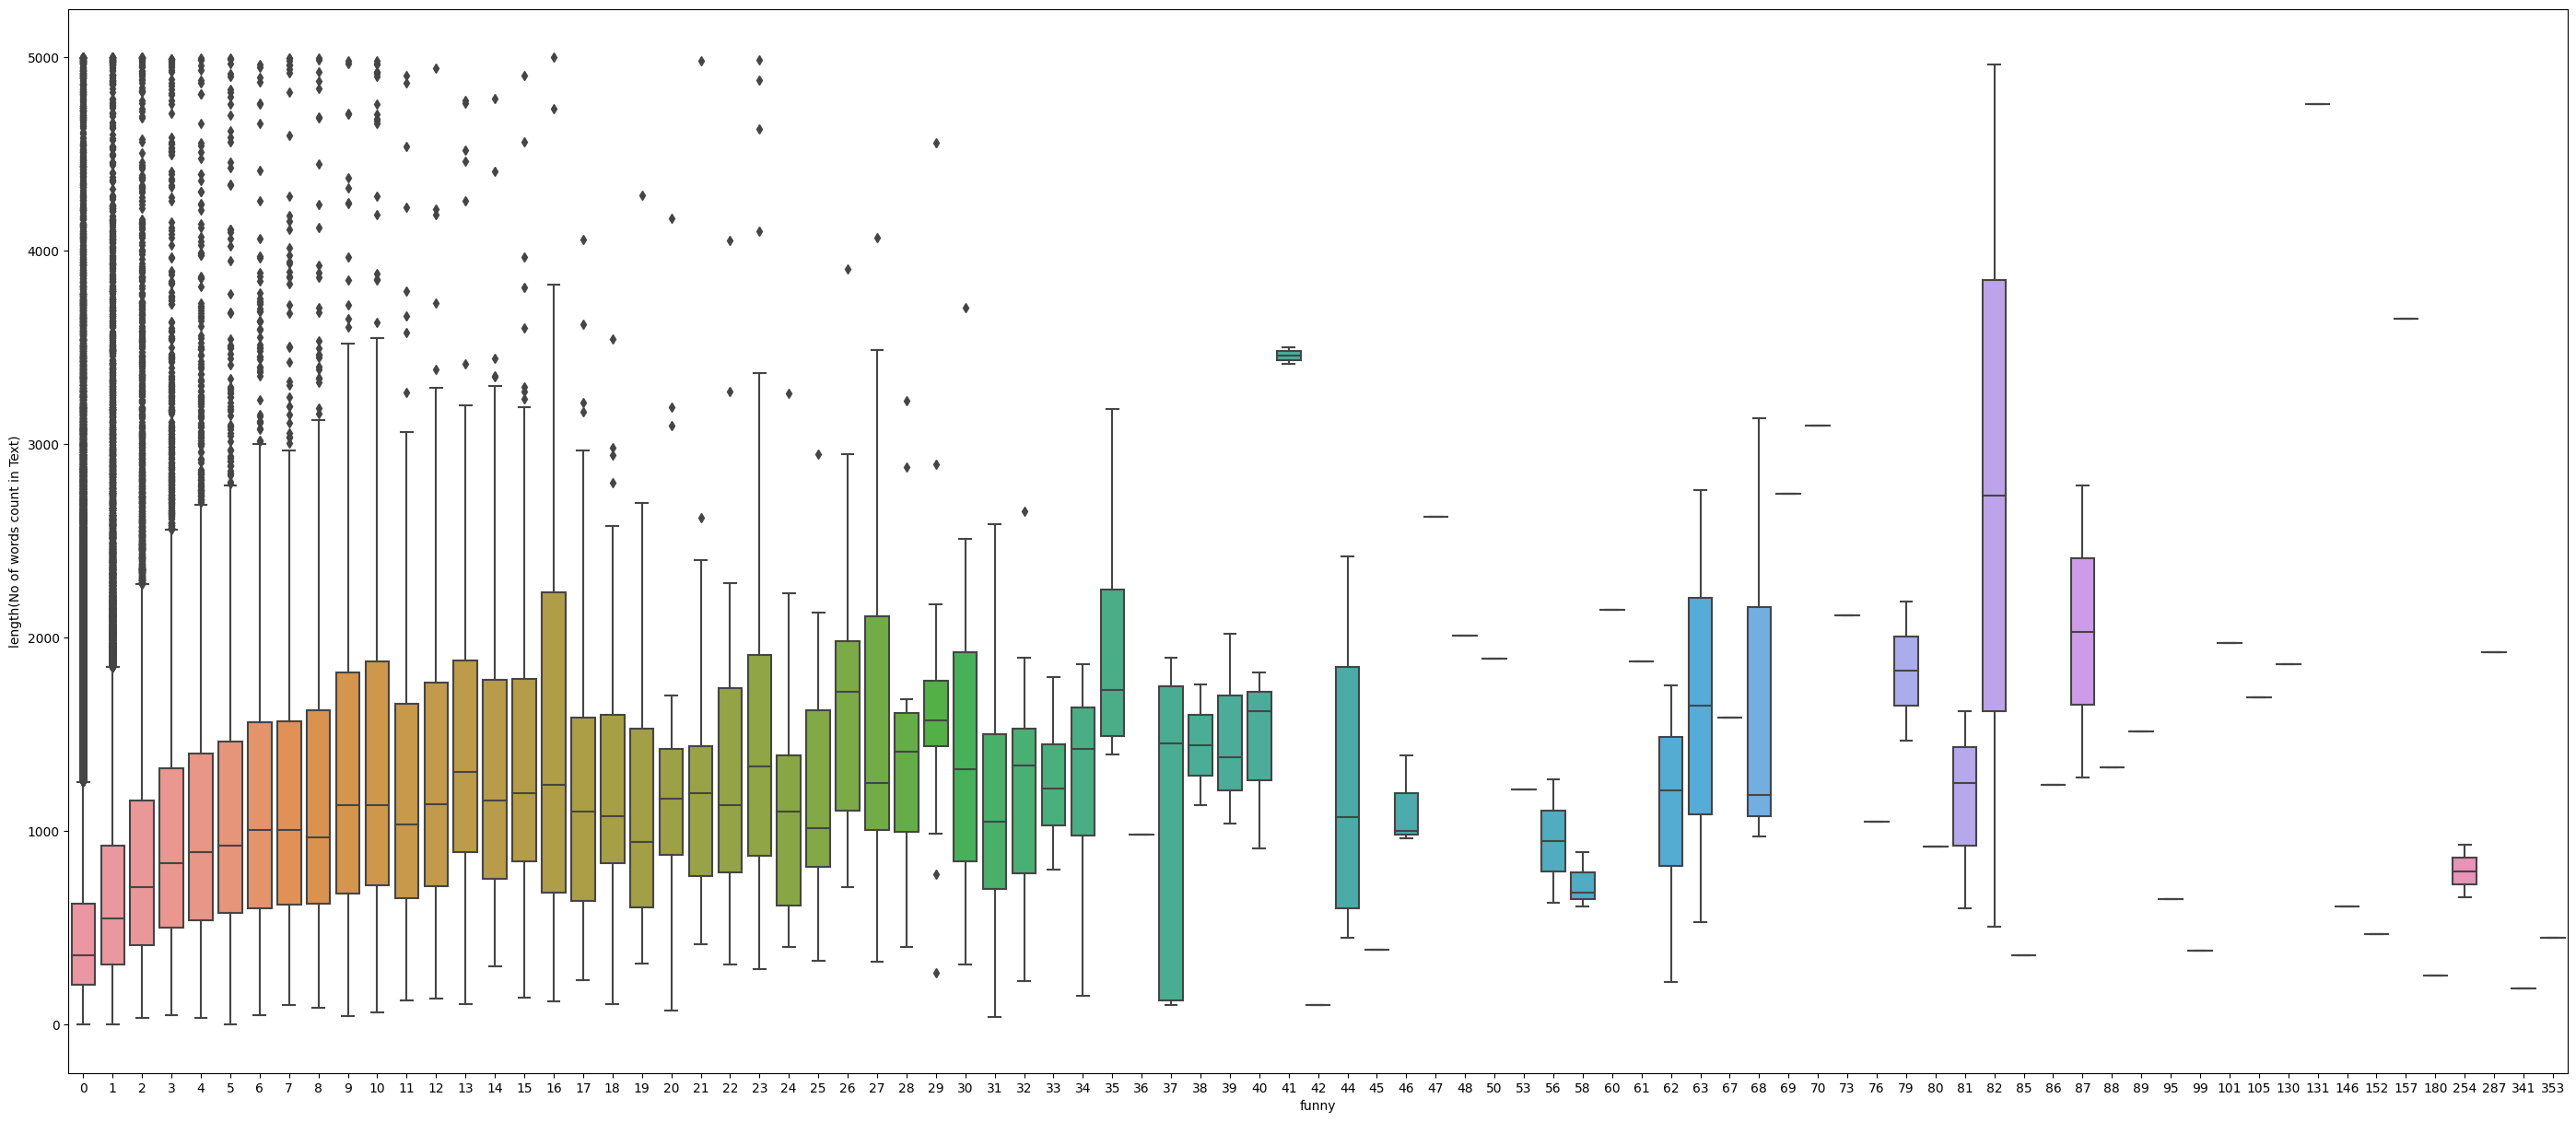

In [25]:
plt.figure(figsize=(35,15))
sns.boxplot(x=review_business_data_merged['funny'],y=review_business_data_merged['length(No of words count in Text)'])

<Axes: xlabel='useful', ylabel='length(No of words count in Text)'>

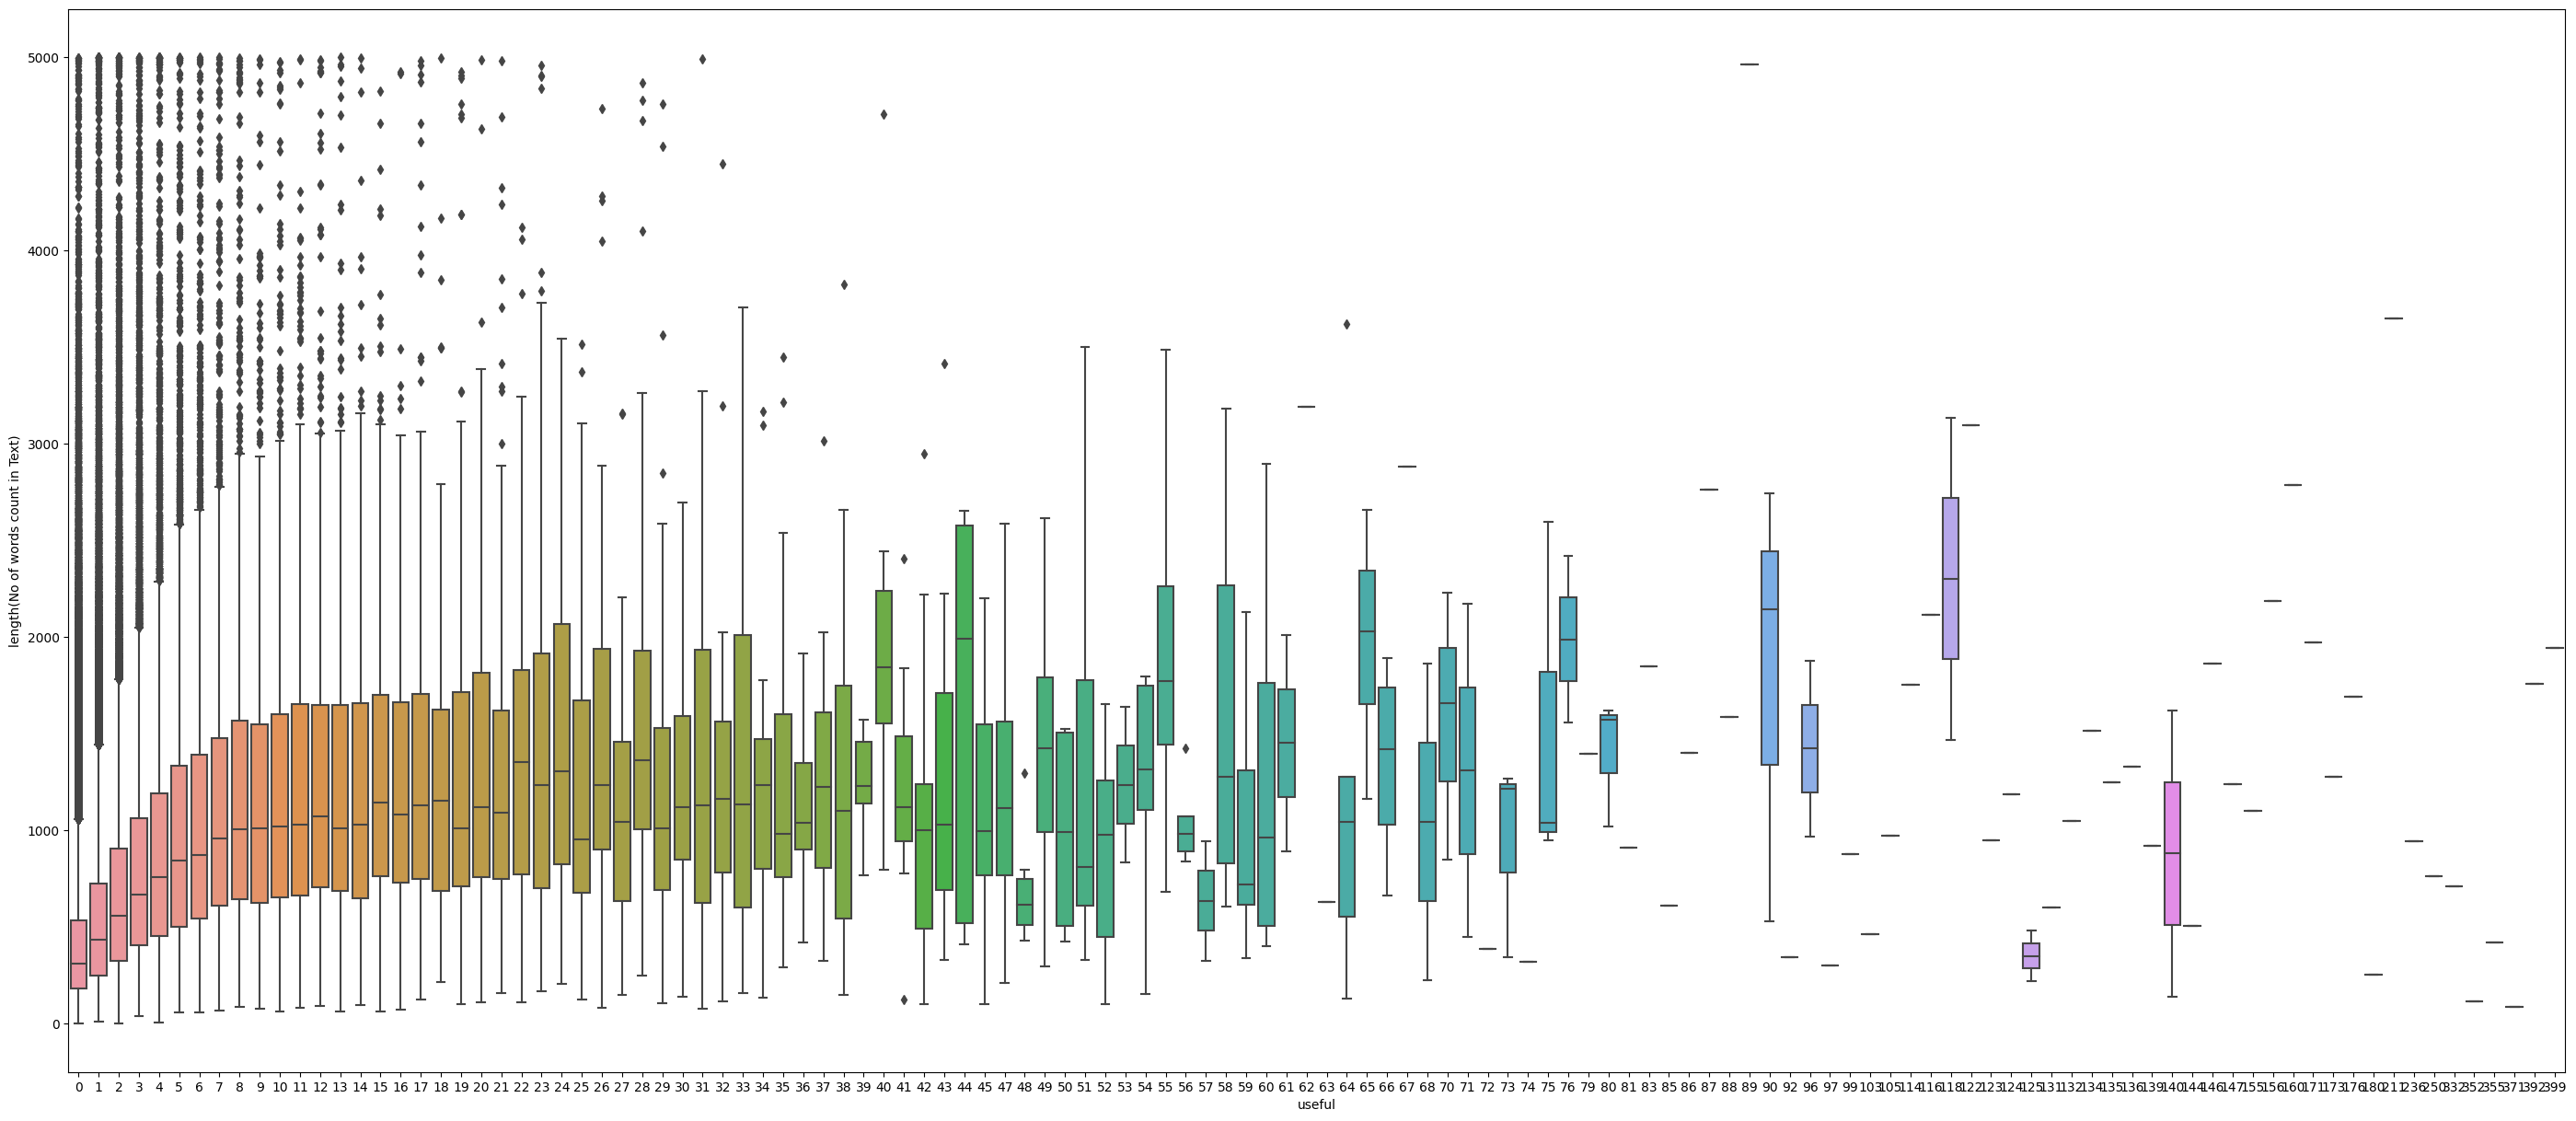

In [26]:
plt.figure(figsize=(35,15))
sns.boxplot(x=review_business_data_merged['useful'],y=review_business_data_merged['length(No of words count in Text)'])

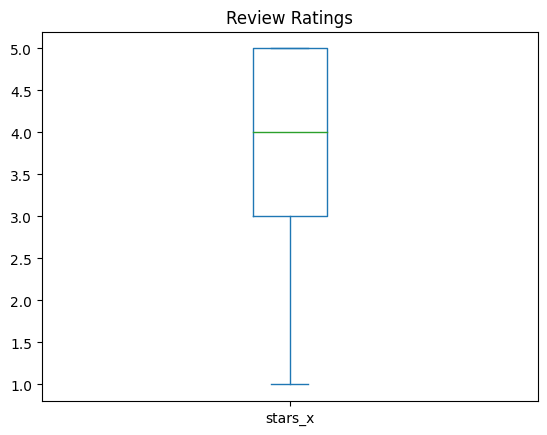

In [27]:
# Box Plot
review_business_data_merged['stars_x'].plot(kind='box', title='Review Ratings')
plt.show()

In [80]:
yelp_attr=pd.read_csv('/content/drive/MyDrive/yelp_business_attributes.csv')
cols_v = list(yelp_attr.columns.values)[1:]
for i in range(len(cols_v)):
    #print(cols_v[i])
    yelp_attr[cols_v[i]].replace('Na', np.nan, inplace=True)
    yelp_attr[cols_v[i]].replace('True', 1, inplace=True)
    yelp_attr[cols_v[i]].replace('False', 0, inplace=True)
yelp_attr.head()

,business_id,AcceptsInsurance,ByAppointmentOnly,BusinessAcceptsCreditCards,BusinessParking_garage,BusinessParking_street,BusinessParking_validated,BusinessParking_lot,BusinessParking_valet,HairSpecializesIn_coloring,...,Corkage,DietaryRestrictions_dairy-free,DietaryRestrictions_gluten-free,DietaryRestrictions_vegan,DietaryRestrictions_kosher,DietaryRestrictions_halal,DietaryRestrictions_soy-free,DietaryRestrictions_vegetarian,AgesAllowed,RestaurantsCounterService
0,FYWN1wneV18bWNgQjJ2GNg,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,He-G7vWjzVUysIKrfNbPUQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8DShNS-LuFqpEWIp0HxijA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PfOCPjBrlQAnz__NXj9h_w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,o9eMRCWt5PkpLDE0gOPtcQ,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
!pip install ptitprince
import ptitprince as pt
rp = pt.RainCloud(x=review_business_data_merged['stars_x'],y=review_business_data_merged['length(No of words count in Text)'], data=review_business_data_merged, width_viol=.8, width_box=.4, orient='h')

ImportError: ignored

In [30]:
businesses_good=review_business_data_merged[(review_business_data_merged['name']=="Starbucks") |
                (review_business_data_merged['name']=="Burger King") |
               (review_business_data_merged['name']=="McDonald's") |
               (review_business_data_merged['name']=="Subway") |
               (review_business_data_merged['name']=="Domino's Pizza")]
#poorly performing businesses
# businesses_bad=review_business_data_merged[(review_business_data_merged['name']=="McDonald's") |
#                 (review_business_data_merged['name']=="Starbucks") |
#                (review_business_data_merged['name']=="Domino's Pizza") |
#                (review_business_data_merged['name']=="Burger King") |
#                (review_business_data_merged['name']=="Subway")]
if((review_business_data_merged['name']=='Carlillos Cocina').any()):
  print("found")

found


In [31]:
#stars classification of reviews on selected companies
grouped_df_good = businesses_good.groupby(by=["name", "stars_x"]).size().reset_index(name="counts")
grouped_df_good['percentage'] = 100 * grouped_df_good['counts'] / grouped_df_good.groupby('name')['counts'].transform('sum')

import plotly.express as px
from plotly.offline import init_notebook_mode, iplot #for offline ploting

plot_1=px.bar(grouped_df_good,
       x='name',
       y=['counts'],
       color='stars_x',
       text=grouped_df_good['percentage'].apply(lambda x: '{0:1.2f}%'.format(x)),
      labels={
                     "name": "Companies",
                     "value": "Reviews Distribution",
                     "stars_y":"Legend"
                 },
                title="Distribution of Reviews Among Companies That Are Doing Good")

iplot(plot_1, filename='plot_1')

In [32]:
import json
user_sk=spark.read.json('/content/yelp_academic_dataset_user.json')
sample_review=user_sk.sample(False, 0.1, seed=0).limit(1000000)
user_pd = sample_review.select("*").toPandas()

# Overview of the converted sample
user_pd.to_csv('yelp_review_sample.csv')
user_pd.head()
# We only use the first 100,000 data in this assignment
users = []
with open('/content/yelp_academic_dataset_user.json') as fl:
    for i, line in enumerate(fl):
        users.append(json.loads(line))
        if i+1 >= 100000:
            break
df = pd.DataFrame(users)
df.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0


In [33]:
# Measures the central tendency for user data
df.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,92.633500,217.217900,91.406500,131.098710,7.478960,3.853158,9.201240,1.526240,0.987990,0.676530,0.399460,7.350100,16.397630,14.679750,14.679750,5.997230,5.130220
std,235.343251,1635.731828,1058.049858,1401.437743,57.493123,0.681401,123.196998,21.728636,31.498351,12.554029,12.538627,69.760793,237.128593,172.564051,172.564051,70.320518,104.642959
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,7.000000,1.000000,1.000000,0.000000,3.530000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,26.000000,5.000000,7.000000,1.000000,3.910000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,80.000000,96.000000,24.000000,31.000000,4.000000,4.280000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,3.000000,2.000000,2.000000,1.000000,0.000000
max,17473.000000,206296.000000,185823.000000,195814.000000,12497.000000,5.000000,12391.000000,4347.000000,7039.000000,1744.000000,2607.000000,8616.000000,28974.000000,13280.000000,13280.000000,9821.000000,14045.000000


In [34]:
# Make column friend_count = number of friends
friend_count = [0 for _ in range(df.shape[0])]
for i in range(df.shape[0]):
    if "friends" in df.columns:
        friend_count[i] = len(df.loc[i, "friends"].split(","))
    else:
        # Handle the case where 'friends' column is not found
        friend_count[i] = 0

friend_count = pd.DataFrame(friend_count)
# Add column friend count column to main db
df['friend_count'] = friend_count

elite_count = [0 for _ in range(df.shape[0])]
for i in range(df.shape[0]):
    elite_count[i] = len(df.loc[i, "elite"].split(","))

elite_count = pd.DataFrame(elite_count)
# print(elite_count)
df['elite_count'] = elite_count  # Add column to df
df = df.drop(["elite"], axis=1) # Drop elite
df.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,friends,fans,average_stars,...,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,friend_count,elite_count
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,3.91,...,56,18,232,844,467,467,239,180,14995,1
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,3.74,...,157,251,1847,7054,3131,3131,1521,1946,4646,14
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,3.32,...,17,3,66,96,119,119,35,18,381,5
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,4.27,...,6,2,12,16,26,26,10,9,131,3
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,3.54,...,0,0,1,1,0,0,0,0,27,1


<Axes: >

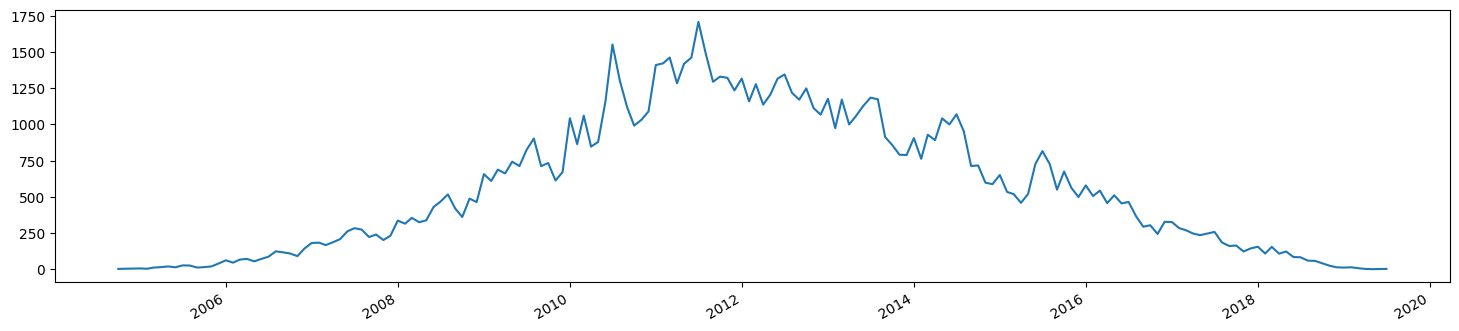

In [46]:
df['yelping_since'] = pd.to_datetime(df['yelping_since'])

df['yelp_since_YRMO'] = df['yelping_since'].map(lambda x: 100*x.year + x.month)
df['yelp_since_year'] = df['yelping_since'].dt.year

df.head()

# Column to store whether compliment has been tagged
tagged_compliment = [0 for _ in range(df.shape[0])]
for i in range(df.shape[0]):
    row_values = df.iloc[i, 7:18].apply(pd.to_numeric, errors='coerce')
    if row_values.sum() > 0:
        tagged_compliment[i] = 1
tagged_compliment = pd.DataFrame(tagged_compliment)
df['tagged_compliment'] = tagged_compliment

# Plot count vs yearmonth, to see the distribution
plt.figure(figsize=(18,4))
yrmo = pd.to_datetime(df['yelp_since_YRMO'], format='%Y%m')
yrmo = pd.DataFrame(yrmo)
yrmo.yelp_since_YRMO.value_counts().plot(kind='line')

<Axes: >

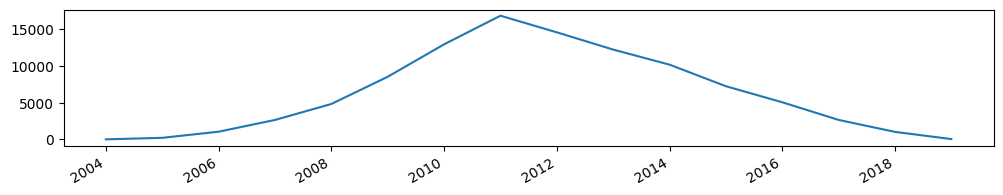

In [37]:
plt.figure(figsize=(12,2))
year = pd.to_datetime(df['yelp_since_year'], format='%Y')
year = pd.DataFrame(year)
year.yelp_since_year.value_counts().plot(kind='line')

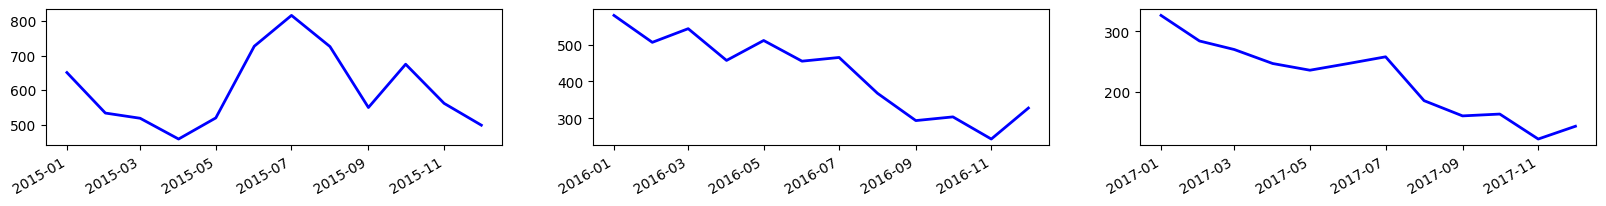

In [47]:
# Time Period 201501-201512 | 201601-201612 | 201701-201712
plt.figure(figsize=(20,2))
period_15 = yrmo[yrmo.yelp_since_YRMO >= pd.to_datetime(201501, format='%Y%m')]
period_15 = period_15[period_15.yelp_since_YRMO <= pd.to_datetime(201512, format='%Y%m')]
period_15 = pd.to_datetime(period_15.yelp_since_YRMO, format='%Y%m')

period_16 = yrmo[yrmo.yelp_since_YRMO >= pd.to_datetime(201601, format='%Y%m')]
period_16 = period_16[period_16.yelp_since_YRMO <= pd.to_datetime(201612, format='%Y%m')]
period_16 = pd.to_datetime(period_16.yelp_since_YRMO, format='%Y%m')

period_17 = yrmo[yrmo.yelp_since_YRMO >= pd.to_datetime(201701, format='%Y%m')]
period_17 = period_17[period_17.yelp_since_YRMO <= pd.to_datetime(201712, format='%Y%m')]
period_17 = pd.to_datetime(period_17.yelp_since_YRMO, format='%Y%m')

plt.subplot(131)
period_15.value_counts().plot(kind='line', linewidth=2, color='b')
plt.subplot(132)
period_16.value_counts().plot(kind='line', linewidth=2, color='b')
plt.subplot(133)
period_17.value_counts().plot(kind='line', linewidth=2, color='b')
plt.show()

<ipython-input-39-f2d399ecccf3>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='average_stars', ylabel='Density'>

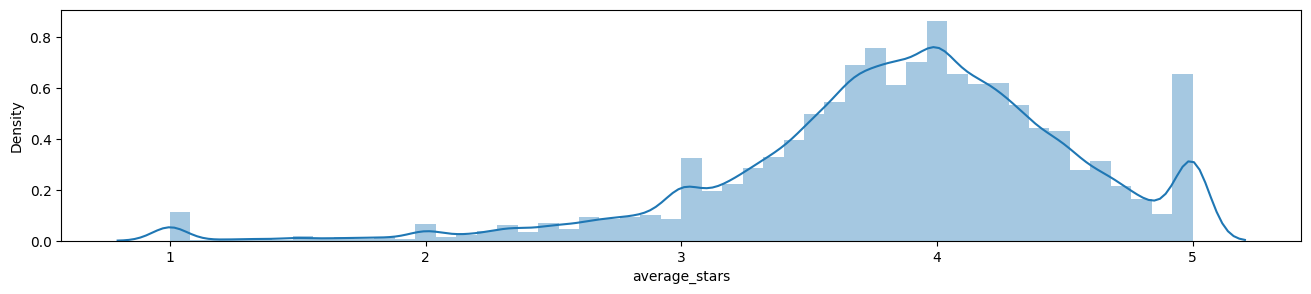

In [39]:
plt.figure(figsize=(16,3))
sns.distplot(df.average_stars)

Users who rate <= 3 Avg Stars: 9.98%
Low Raters, <4 Avg Stars: 54.69%
High Raters >=4 Avg Stars: 45.31%


<ipython-input-40-5d58e71a0f8a>:25: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-40-5d58e71a0f8a>:29: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-40-5d58e71a0f8a>:33: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use

<Axes: xlabel='friend_count', ylabel='Density'>

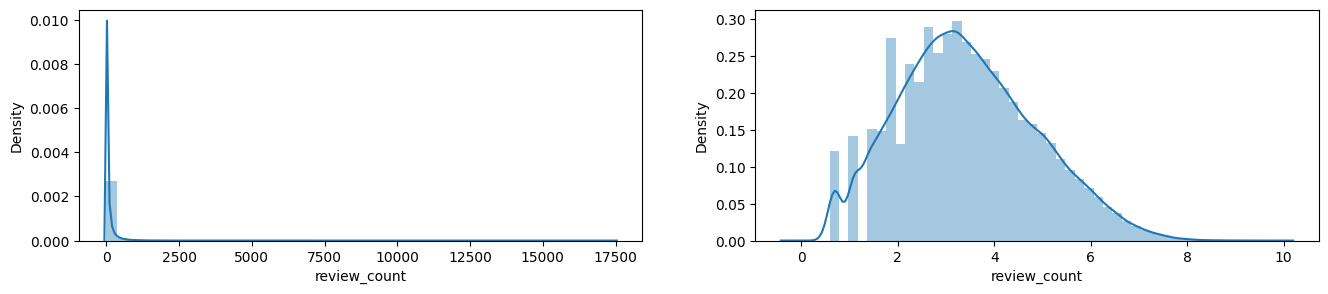

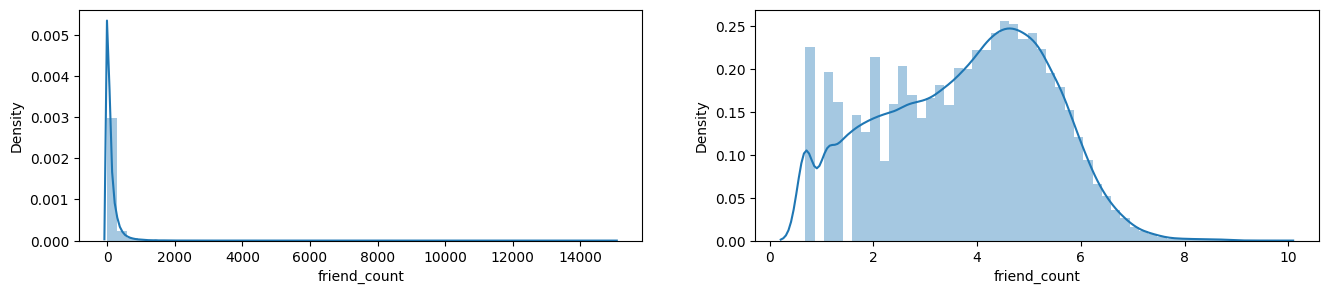

In [40]:
import numpy as np
raters_below_3 = len(df.loc[df.average_stars <= 3])
print("Users who rate <= 3 Avg Stars: {:0.02%}".format(raters_below_3/df.shape[0]))

low_raters = len(df.loc[df.average_stars < 4])
high_raters = len(df.loc[df.average_stars >= 4])
print("Low Raters, <4 Avg Stars: {:0.02%}".format(low_raters/df.shape[0]))
print("High Raters >=4 Avg Stars: {:0.02%}".format(high_raters/df.shape[0]))

# Make a column raters, which is 1 for high raters (>=4 avg stars), and 0 for the rest (<4)

raters = [0 for _ in range(df.shape[0])]
for i in range(df.shape[0]):
    if df.loc[i,"average_stars"] >= 4:
        raters[i] = 1
#     elif float(3) <= df.loc[i,"average_stars"] < float(4):
#         rating[i] = "M"
#     else:
#         raters[i] = "H"
# Add column to main df
df['raters'] = raters

plt.figure(figsize=(16,3))
plt.subplot(121)
sns.distplot(df.review_count)

# Taking a Normal Distribution as review_count heavily skewed
plt.subplot(122)
sns.distplot(df.review_count.apply(np.log1p))

plt.figure(figsize=(16,3))
plt.subplot(121)
sns.distplot(df.friend_count)

# Taking a Normal Distribution as friend_count heavily skewed
plt.subplot(122)
sns.distplot(df.friend_count.apply(np.log1p))

<ipython-input-41-1caacb2f18ff>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-41-1caacb2f18ff>:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-41-1caacb2f18ff>:11: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use e

People who leave useful reviews: 95%


<ipython-input-41-1caacb2f18ff>:22: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-41-1caacb2f18ff>:26: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='useful', ylabel='Density'>

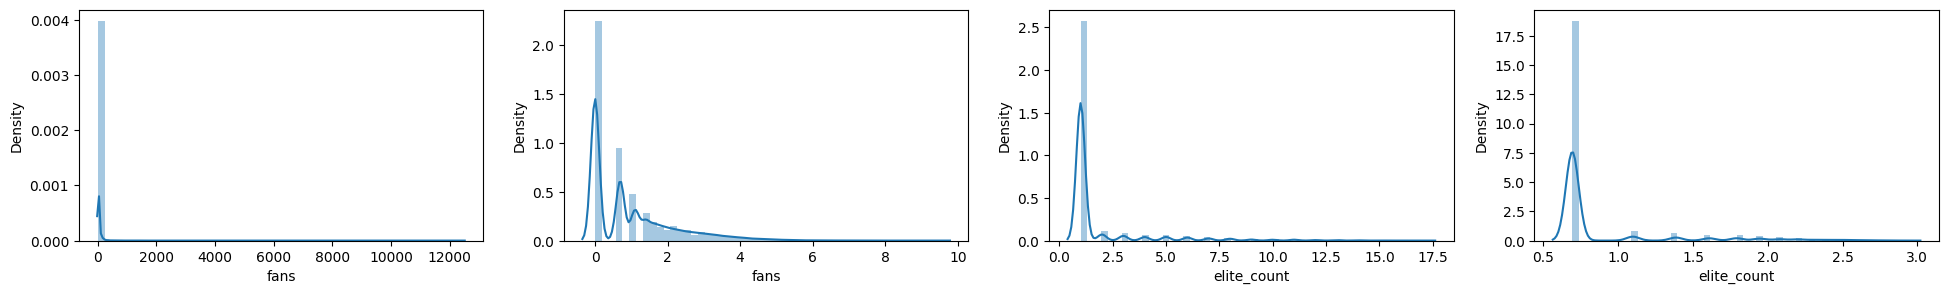

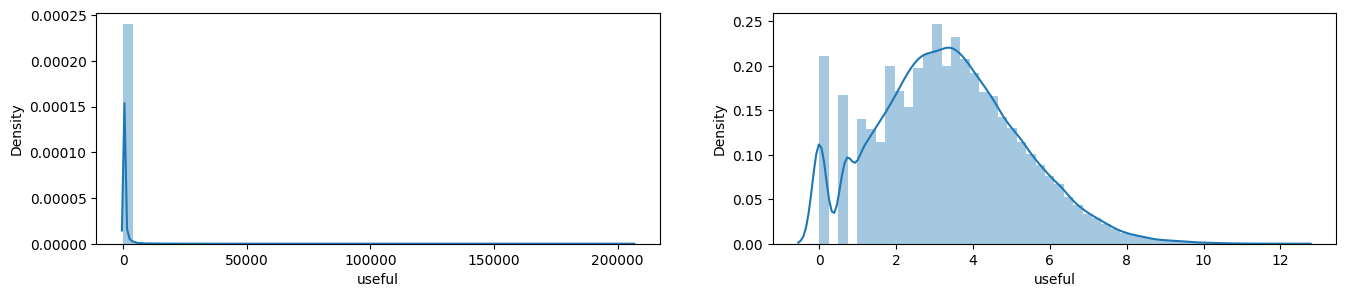

In [41]:
plt.figure(figsize=(24,3))

plt.subplot(141)
sns.distplot(df.fans)

# Taking a Normal Distribution as fans heavily skewed
plt.subplot(142)
sns.distplot(df.fans.apply(np.log1p))

plt.subplot(143)
sns.distplot(df.elite_count)

# Taking a Normal Distribution as elite_count heavily skewed
plt.subplot(144)
sns.distplot(df.elite_count.apply(np.log1p))

useful_reviews = len(df.loc[df.useful > 0])
print("People who leave useful reviews: {:0.0%}".format(useful_reviews/df.shape[0]))

plt.figure(figsize=(16,3))
plt.subplot(121)
sns.distplot(df.useful)

# Taking a Normal Distribution as useful count heavily skewed
plt.subplot(122)
sns.distplot(df.useful.apply(np.log1p))

In [50]:
from sklearn.preprocessing import StandardScaler

# Don't scale columns: yelp_since_year, yelp_since_YRMO, elite
features = ['review_count', 'useful', 'funny', 'cool', 'fans',
       'average_stars', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos',
       'friend_count', 'elite_count', 'raters', 'tagged_compliment']
x = df.loc[:, features]
x = StandardScaler().fit_transform(x)

# Adding column names back to data, and converting ndarray back to datafram obj
df_train = pd.DataFrame(x, columns=features)
df_train.head()

# Eyebaling central tendency, and qc-ing scaled values
df_train.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,...,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,friend_count,elite_count,raters,tagged_compliment
count,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,...,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,100000.0
mean,2.273737e-17,3.410605e-18,4.547474e-18,-1.449507e-17,1.222134e-17,6.923528e-16,1.847411e-17,-1.293188e-17,-2.700062e-18,4.263256e-18,...,3.694822e-18,8.242296e-18,6.536993e-18,6.536993e-18,6.536993e-18,7.887024e-18,-3.183231e-17,-3.751666e-17,-7.105427e-17,0.0
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,...,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,0.0
min,-3.936122e-01,-1.327962e-01,-8.639192e-02,-9.354634e-02,-1.300851e-01,-4.187216e+00,-7.468758e-02,-7.024130e-02,-3.136656e-02,-5.388974e-02,...,-1.053620e-01,-6.915114e-02,-8.506884e-02,-8.506884e-02,-8.528464e-02,-4.902619e-02,-4.583488e-01,-3.598673e-01,-9.101396e-01,0.0
25%,-3.511208e-01,-1.285168e-01,-8.544678e-02,-9.283278e-02,-1.300851e-01,-4.742575e-01,-7.468758e-02,-7.024130e-02,-3.136656e-02,-5.388974e-02,...,-1.053620e-01,-6.915114e-02,-8.506884e-02,-8.506884e-02,-8.528464e-02,-4.902619e-02,-4.180392e-01,-3.598673e-01,-9.101396e-01,0.0
50%,-2.788855e-01,-1.169011e-01,-8.166622e-02,-8.855144e-02,-1.126916e-01,8.342005e-02,-7.468758e-02,-7.024130e-02,-3.136656e-02,-5.388974e-02,...,-1.053620e-01,-6.915114e-02,-8.506884e-02,-8.506884e-02,-8.528464e-02,-4.902619e-02,-2.751236e-01,-3.598673e-01,-9.101396e-01,0.0
75%,-5.368143e-02,-7.410659e-02,-6.370856e-02,-7.142608e-02,-6.051119e-02,6.264219e-01,-6.657046e-02,-2.421885e-02,-3.136656e-02,-5.388974e-02,...,-7.669246e-02,-5.649971e-02,-7.347888e-02,-7.347888e-02,-7.106397e-02,-4.902619e-02,7.666870e-02,-3.598673e-01,1.098733e+00,0.0
max,7.385151e+01,1.259863e+02,1.755423e+02,1.396308e+02,2.172361e+02,1.683074e+00,1.005046e+02,1.999893e+02,2.234418e+02,1.388663e+02,...,1.234030e+02,1.221183e+02,7.687225e+01,7.687225e+01,1.395759e+02,1.341699e+02,5.448721e+01,7.473765e+00,1.098733e+00,0.0


In [51]:
# Covariance matrix of scaled data
cov = df_train.cov()
cov.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-51-2735f3c4a8c3>:3: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,friend_count,elite_count,raters,tagged_compliment
review_count,1.00,0.68,0.58,0.61,0.49,-0.01,0.36,0.27,0.16,0.22,0.16,0.45,0.34,0.41,0.41,0.42,0.28,0.45,0.66,-0.09,0.00
useful,0.68,1.00,0.95,0.99,0.59,-0.00,0.63,0.44,0.28,0.32,0.25,0.68,0.60,0.72,0.72,0.70,0.65,0.52,0.35,-0.03,0.00
funny,0.58,0.95,1.00,0.97,0.53,-0.00,0.65,0.44,0.29,0.34,0.25,0.64,0.56,0.72,0.72,0.71,0.64,0.44,0.26,-0.03,0.00
cool,0.61,0.99,0.97,1.00,0.55,0.00,0.65,0.44,0.29,0.32,0.24,0.67,0.60,0.73,0.73,0.70,0.67,0.48,0.29,-0.02,0.00
fans,0.49,0.59,0.53,0.55,1.00,0.01,0.39,0.26,0.15,0.29,0.17,0.48,0.48,0.45,0.45,0.41,0.37,0.54,0.33,-0.02,0.00
average_stars,-0.01,-0.00,-0.00,0.00,0.01,1.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.04,0.02,0.72,0.00
compliment_hot,0.36,0.63,0.65,0.65,0.39,0.00,1.00,0.70,0.59,0.73,0.55,0.84,0.70,0.93,0.93,0.82,0.76,0.37,0.24,-0.02,0.00
compliment_more,0.27,0.44,0.44,0.44,0.26,-0.00,0.70,1.00,0.95,0.80,0.92,0.79,0.49,0.67,0.67,0.78,0.42,0.23,0.17,-0.02,0.00
compliment_profile,0.16,0.28,0.29,0.29,0.15,-0.00,0.59,0.95,1.00,0.79,0.95,0.67,0.39,0.54,0.54,0.63,0.33,0.13,0.09,-0.01,0.00
compliment_cute,0.22,0.32,0.34,0.32,0.29,-0.00,0.73,0.80,0.79,1.00,0.81,0.69,0.48,0.61,0.61,0.59,0.37,0.25,0.15,-0.02,0.00


In [52]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-52-f0f86bb9996e>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-52-f0f86bb9996e>:2: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3931: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3932: RuntimeWarning:

All-NaN slice encountered



,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,friend_count,elite_count,yelp_since_YRMO,yelp_since_year,raters,tagged_compliment
review_count,1.00,0.68,0.58,0.61,0.49,-0.01,0.36,0.27,0.16,0.22,0.16,0.45,0.34,0.41,0.41,0.42,0.28,0.45,0.66,-0.21,-0.21,-0.09,nan
useful,0.68,1.00,0.95,0.99,0.59,-0.00,0.63,0.44,0.28,0.32,0.25,0.68,0.60,0.72,0.72,0.70,0.65,0.52,0.35,-0.09,-0.09,-0.03,nan
funny,0.58,0.95,1.00,0.97,0.53,-0.00,0.65,0.44,0.29,0.34,0.25,0.64,0.56,0.72,0.72,0.71,0.64,0.44,0.26,-0.07,-0.07,-0.03,nan
cool,0.61,0.99,0.97,1.00,0.55,0.00,0.65,0.44,0.29,0.32,0.24,0.67,0.60,0.73,0.73,0.70,0.67,0.48,0.29,-0.06,-0.06,-0.02,nan
fans,0.49,0.59,0.53,0.55,1.00,0.01,0.39,0.26,0.15,0.29,0.17,0.48,0.48,0.45,0.45,0.41,0.37,0.54,0.33,-0.08,-0.08,-0.02,nan
average_stars,-0.01,-0.00,-0.00,0.00,0.01,1.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.04,0.02,0.04,0.04,0.72,nan
compliment_hot,0.36,0.63,0.65,0.65,0.39,0.00,1.00,0.70,0.59,0.73,0.55,0.84,0.70,0.93,0.93,0.82,0.76,0.37,0.24,-0.08,-0.08,-0.02,nan
compliment_more,0.27,0.44,0.44,0.44,0.26,-0.00,0.70,1.00,0.95,0.80,0.92,0.79,0.49,0.67,0.67,0.78,0.42,0.23,0.17,-0.06,-0.06,-0.02,nan
compliment_profile,0.16,0.28,0.29,0.29,0.15,-0.00,0.59,0.95,1.00,0.79,0.95,0.67,0.39,0.54,0.54,0.63,0.33,0.13,0.09,-0.04,-0.04,-0.01,nan
compliment_cute,0.22,0.32,0.34,0.32,0.29,-0.00,0.73,0.80,0.79,1.00,0.81,0.69,0.48,0.61,0.61,0.59,0.37,0.25,0.15,-0.08,-0.08,-0.02,nan


In [42]:
# For creating wordcloud
import string # for finding punctuation in text
# function for pre-processing the text of reviews
# this function remove punctuation and stopwords
import nltk
from wordcloud import WordCloud, STOPWORDS # this module is for making wordcloud in python
# difine wordcloud function from wordcloud library. set some parameteres for beatuful plotting

# Defining some functions for later use for wordcloud
def preprocess(x):
    x = re.sub('[^a-z\s]', '', x.lower())                  # get rid of noise
    x = [w for w in x.split() if w not in set(stopwords)]  # remove stopwords
    return ' '.join(x) # then join the text again
# let's find out which stopwords need to remove. We'll use english stopwords.
i = nltk.corpus.stopwords.words('english')
# punctuations to remove
j = list(string.punctuation)
# finally let's combine all of these
stopwords = set(i).union(j)

Starbucks = review_business_data_merged.loc[review_business_data_merged['name'] == "Starbucks"]
# clear the text
Starbucks['text_clear'] = Starbucks['text'].apply(preprocess)

wc = WordCloud(width=1600, height=800, random_state=1, max_words=200000000)
# generate word cloud
wc.generate(str(Starbucks['text_clear']))
plt.figure(figsize=(20,10), facecolor='k')
# add title to the graph
plt.title("Customers reviews about 'Starbucks'", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# after lot of configuration finally plot the graph
plt.show()

LookupError: ignored

In [55]:
from sklearn.decomposition import PCA
df_review = df_train.loc[:, ['funny', 'cool', 'useful']]  # Make df of these 3 features
pca = PCA(n_components=1)
review_feedback = pca.fit_transform(df_review)
review_feedback = pd.DataFrame(data=review_feedback)
print('PCA Components:', pca.components_)
print('Ratio of Variance Explained:', pca.explained_variance_ratio_ )

PCA Components: [[0.57352273 0.58073616 0.57776915]]
Ratio of Variance Explained: [0.9813594]


In [56]:
df_popularity = df_train.loc[:, ['fans', 'friend_count']]
pca = PCA(n_components=1)
popularity_feedback = pca.fit_transform(df_popularity)
popularity_feedback = pd.DataFrame(data=popularity_feedback)
print('PCA Components:', pca.components_)
print('Ratio of Variance Explained:', pca.explained_variance_ratio_ )

PCA Components: [[0.70710678 0.70710678]]
Ratio of Variance Explained: [0.77234225]


In [57]:
df_active = df_train.loc[:, ['review_count', 'elite_count']]
pca4 = PCA(n_components=1)
active_feedback = pca4.fit_transform(df_active)
active_feedback = pd.DataFrame(data=active_feedback)
print('PCA Components:', pca.components_)
print('Ratio of Variance Explained:', pca.explained_variance_ratio_ )

PCA Components: [[0.70710678 0.70710678]]
Ratio of Variance Explained: [0.77234225]


In [63]:
df_compliments = df_train.loc[:, ['compliment_hot', 'compliment_more', 'compliment_profile',
       'compliment_cute', 'compliment_list', 'compliment_note',
       'compliment_plain', 'compliment_cool', 'compliment_funny',
       'compliment_writer', 'compliment_photos']]
pca = PCA(n_components=1)
compliments_feedback = pca.fit_transform(df_compliments)
compliments_feedback = pd.DataFrame(data=compliments_feedback)
print('PCA Components:', pca.components_)
print('Ratio of Variance Explained:', pca.explained_variance_ratio_ )

PCA Components: [[0.32806992 0.31196252 0.27903664 0.28404901 0.2665252  0.33124188
  0.27350879 0.33052892 0.33052892 0.31394041 0.25275083]]
Ratio of Variance Explained: [0.7205013]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

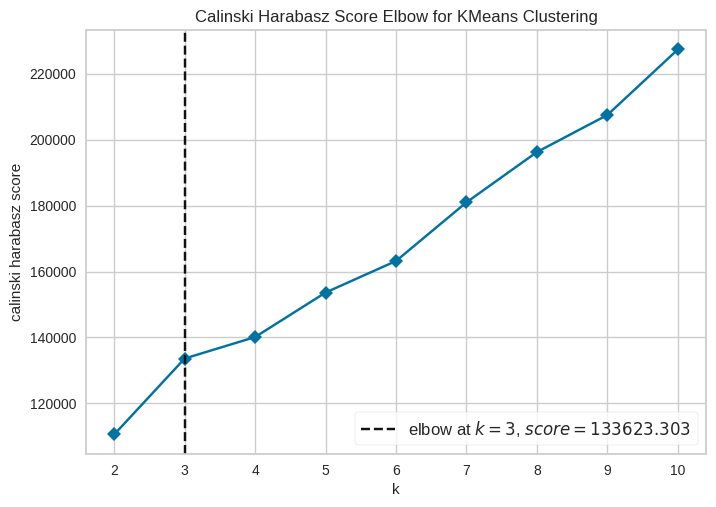

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [66]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
comp_star = pd.concat([compliments_feedback, df.loc[:,'average_stars']], axis=1)
# Convert feature names to strings
comp_star.columns = comp_star.columns.astype(str)
model = KElbowVisualizer(KMeans(), k=10, metric='calinski_harabasz', timings=False)
model.fit(comp_star)
model.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



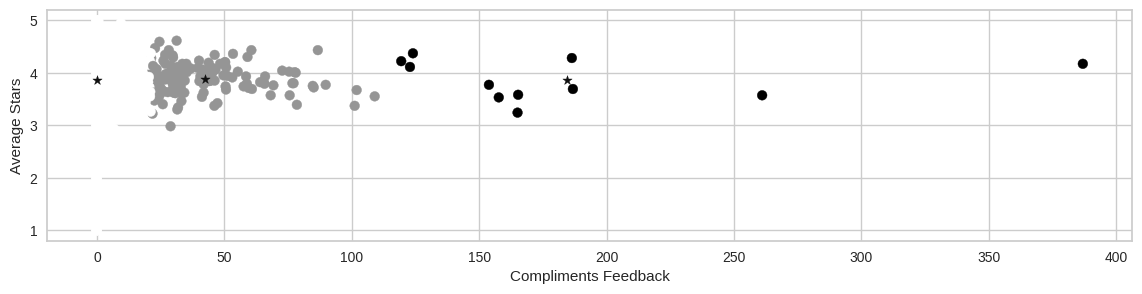

In [67]:
model = KMeans(n_clusters=3)
model.fit(comp_star)
all_predictions = model.predict(comp_star)
centroids = model.cluster_centers_

plt.figure(figsize=(14, 3))
plt.scatter(comp_star.iloc[:,0].values, comp_star.iloc[:,1].values, c=all_predictions)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='#0f0f0f')
plt.xlabel('Compliments Feedback')
plt.ylabel('Average Stars')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



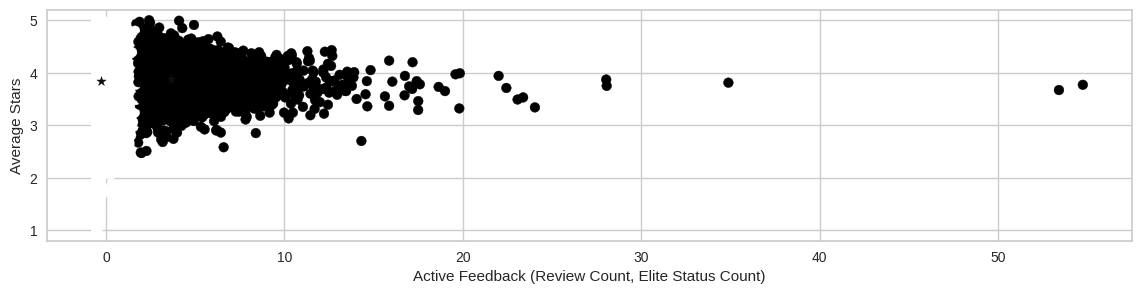

In [69]:
act_star = pd.concat([active_feedback, df.loc[:,'average_stars']], axis=1)
# Convert feature names to strings
act_star.columns = act_star.columns.astype(str)
model = KMeans(n_clusters=2)
model.fit(act_star)
all_predictions = model.predict(act_star)
centroids = model.cluster_centers_

plt.figure(figsize=(14, 3))
plt.scatter(act_star.iloc[:,0].values, act_star.iloc[:,1].values, c=all_predictions)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='#0f0f0f')
plt.xlabel('Active Feedback (Review Count, Elite Status Count)')
plt.ylabel('Average Stars')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



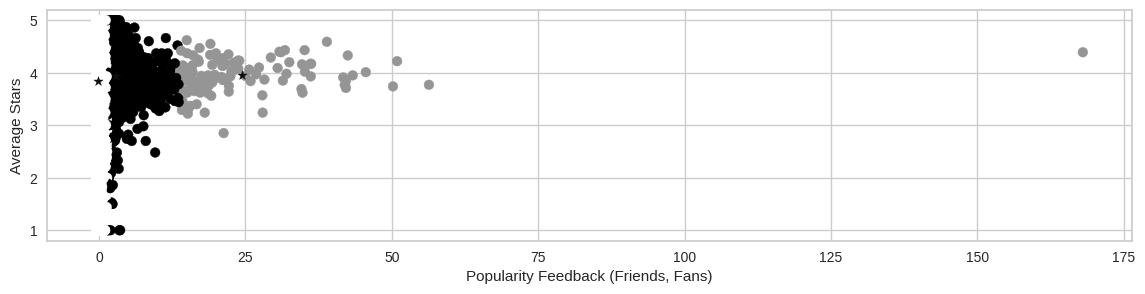

In [71]:
pop_stars = pd.concat([popularity_feedback, df.loc[:,'average_stars']], axis=1)
# Convert feature names to strings
pop_stars.columns = pop_stars.columns.astype(str)
model = KMeans(n_clusters=3)
model.fit(pop_stars)
all_predictions = model.predict(pop_stars)
centroids = model.cluster_centers_

plt.figure(figsize=(14, 3))
plt.scatter(pop_stars.iloc[:,0].values, pop_stars.iloc[:,1].values, c=all_predictions)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='#0f0f0f')
plt.xlabel('Popularity Feedback (Friends, Fans)')
plt.ylabel('Average Stars')
plt.show()

Correlation: 59.64%


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



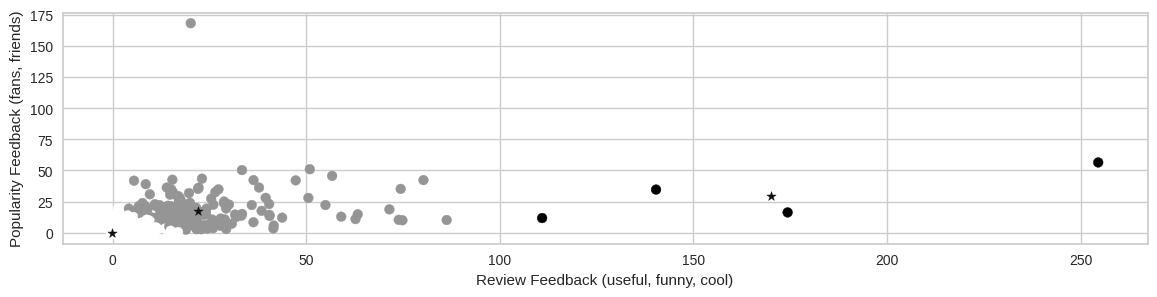

In [73]:
rev_pop = pd.concat([review_feedback, popularity_feedback], axis=1)
print("Correlation: {:0.02%}".format((rev_pop.corr()).iloc[0,1]))
model = KMeans(n_clusters=3)
model.fit(rev_pop)
all_predictions = model.predict(rev_pop)
centroids = model.cluster_centers_

plt.figure(figsize=(14, 3))
plt.scatter(rev_pop.iloc[:,0].values, rev_pop.iloc[:,1].values, c=all_predictions)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='#0f0f0f')
plt.xlabel('Review Feedback (useful, funny, cool)')
plt.ylabel('Popularity Feedback (fans, friends)')
plt.show()

Correlation: 51.17%


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Text(0, 0.5, 'Active Feedback (review, elite counts)')

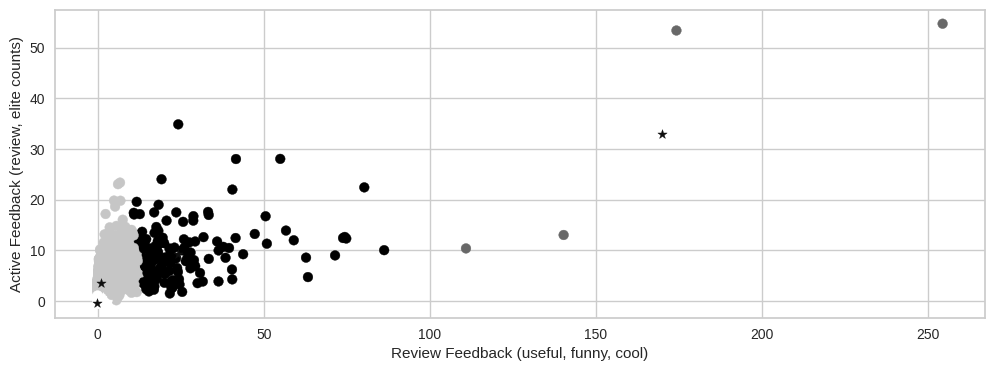

In [74]:
rev_act = pd.concat([review_feedback, active_feedback], axis=1)
print("Correlation: {:0.02%}".format((rev_act.corr()).iloc[0,1]))
model = KMeans(n_clusters=4)
model.fit(rev_act)
all_predictions = model.predict(rev_act)
centroids = model.cluster_centers_

plt.figure(figsize=(12,4))
plt.scatter(rev_act.iloc[:,0].values, rev_act.iloc[:,1].values, c=all_predictions)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='#0f0f0f')
plt.xlabel('Review Feedback (useful, funny, cool)')
plt.ylabel('Active Feedback (review, elite counts)')

Top Performing Categories:
Beauty & Spas, Nail Salons                            1012
Restaurants, Pizza                                     935
Nail Salons, Beauty & Spas                             934
Pizza, Restaurants                                     823
Restaurants, Mexican                                   728
Restaurants, Chinese                                   708
Mexican, Restaurants                                   672
Chinese, Restaurants                                   651
Food, Coffee & Tea                                     508
Beauty & Spas, Hair Salons                             493
Hair Salons, Beauty & Spas                             480
Coffee & Tea, Food                                     473
Automotive, Auto Repair                                361
Auto Repair, Automotive                                351
Grocery, Food                                          329
Italian, Restaurants                                   328
Food, Grocery                

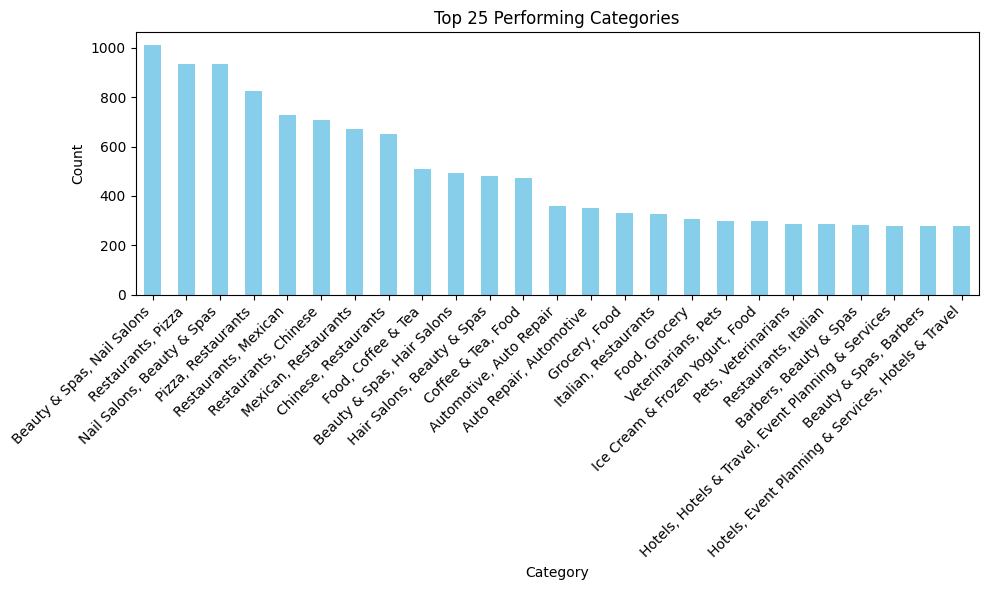

In [43]:
category_counts = business_pd['categories'].str.split(';').explode().value_counts()
# Get the top N categories
top_n = 25
top_categories = category_counts.head(top_n)

# Display the top performing categories
print("Top Performing Categories:")
print(top_categories)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_categories.plot(kind='bar', color='skyblue')
plt.title(f"Top {top_n} Performing Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

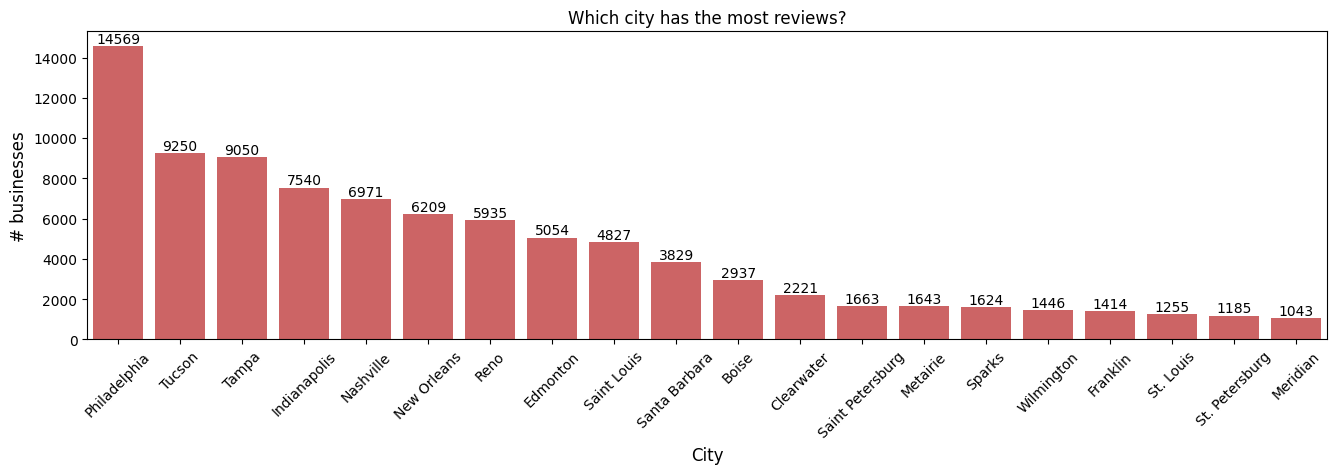

In [61]:
#Get the distribution of the ratings
color = sns.color_palette()
x=business_pd['city'].value_counts()
x=x.sort_values(ascending=False)
x=x.iloc[0:20]
plt.figure(figsize=(16,4))
ax = sns.barplot(x = x.index, y = x.values, alpha=0.8, color=color[3])
plt.title("Which city has the most reviews?")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('City', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [ ]:
user_agg=reviews_pd.groupby('user_id').agg({'review_id':['count'],'date':['min','max'],
                                'useful':['sum'],'funny':['sum'],'cool':['sum'],
                               'stars':['mean']})
user_agg=user_agg.sort_values([('review_id','count')],ascending=False)
print("          Top 10 Users in Yelp")
user_agg.head(10)

In [ ]:
business_pd['name'] = business_pd['business_id'].map(df_yelp_business_restaurants.set_index('business_id')['name'])
# take the top only 20 most occurances restaurants for analysis. Because the dataset has over thousand business id. It will be really inefficient if we take all of the business name
top_restaurants = business_pd.name.value_counts().index[:20].tolist()
# create a new dataframe called 'df_review_top' that only contains the reviews of 'top_restaurants'
df_review_top = business_pd.loc[business_pd['name'].isin(top_restaurants)]
# now we take the name column and count mean of stars of each unique business name (I am using pandas groupby function for this. If you don't know what pandas groupby function does, please search on Google)
# then sort values in ascending order
# then plot the graph
df_review_top.groupby(df_review_top.name)['stars_x'].mean().sort_values(ascending=True).plot(kind='barh',figsize=(12, 10))
# set y ticks font size to 18 for easy readable purposes.
plt.yticks(fontsize=18)
# set the title of the graph
plt.title('Top rated restaurants on Yelp',fontsize=20)
# set y label of the graph and change fontsize to 18 for readablity purposes.
plt.ylabel('Restaurants names', fontsize=18)
# set x label to 'Ratings'
plt.xlabel('Ratings', fontsize=18)
# now finally show the graph in a new window.
plt.show()

In [ ]:
# this dataset contains all of the business customer reviews and their date
df_yelp_review = pd.read_csv('/content/drive/MyDrive/yelp_review_sample.csv')
# import yelp_tip.csv file.
# this dataset contains user tips for business.
#df_yelp_tip = pd.read_csv('/content/drive/MyDrive/tip_review_sample.csv')
df_yelp_review.head(5)
df_yelp_review['name'] = df_yelp_review['business_id'].map(df_yelp_business_restaurants.set_index('business_id')['name'])
# take the top only 20 most occurances restaurants for analysis. Because the dataset has over thousand business id. It will be really inefficient if we take all of the business name
top_restaurants = df_yelp_review.name.value_counts().index[:20].tolist()
# create a new dataframe called 'df_review_top' that only contains the reviews of 'top_restaurants'
df_review_top = df_yelp_review.loc[df_yelp_review['name'].isin(top_restaurants)]
# now we take the name column and count mean of stars of each unique business name (I am using pandas groupby function for this. If you don't know what pandas groupby function does, please search on Google)
# then sort values in ascending order
# then plot the graph
df_review_top.groupby(df_review_top.name)['stars'].mean().sort_values(ascending=True).plot(kind='barh',figsize=(12, 10))
# set y ticks font size to 18 for easy readable purposes.
plt.yticks(fontsize=18)
# set the title of the graph
plt.title('Top rated restaurants on Yelp',fontsize=20)
# set y label of the graph and change fontsize to 18 for readablity purposes.
plt.ylabel('Restaurants names', fontsize=18)
# set x label to 'Ratings'
plt.xlabel('Ratings', fontsize=18)
# now finally show the graph in a new window.
plt.show()

In [ ]:
!pip3 install sentence_transformers
#!pip3 install transformers

In [ ]:
# Import necessary libraries
import pandas as pd
import plotly as py
import cufflinks
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from branca.element import Figure
import folium
import matplotlib.pyplot as pPlot
import numpy as npy
from PIL import Image
from IPython.display import Image as img

In [ ]:

print(review_business_data_merged.iloc[123]['text'])
print(review_business_data_merged.iloc[1243]['text'])
print(review_business_data_merged.iloc[23]['text'])
print(review_business_data_merged.iloc[389]['text'])


In [ ]:

# starts 4-5: Positive(1), stars 1-2: Negative(3), stars 3: Neutral(2)
def map_sentiment(rating):
    if(int(rating)==3):
        return 2
    elif(int(rating)<3):
        return 3
    else:
        return 1

review_business_data_merged['stars_x']
review_sentiments=[map_sentiment(s) for s in review_business_data_merged['stars_x']]
review_business_data_merged['sentiments']=review_sentiments

In [ ]:
# Get most review business ids
ids=review_business_data_merged.value_counts(['business_id'])
ids=[list(ids.index[i])[0] for i in range(len(ids))]
data0=review_business_data_merged[review_business_data_merged['business_id']==ids[0]]
data1=review_business_data_merged[review_business_data_merged['business_id']==ids[1]]
data2=review_business_data_merged[review_business_data_merged['business_id']==ids[2]]
data3=review_business_data_merged[review_business_data_merged['business_id']==ids[3]]
data4=review_business_data_merged[review_business_data_merged['business_id']==ids[4]]
data=pd.concat([data0,data1,data2,data3,data4])
len(data)
data.to_csv('yelp_reviews_business_merged.csv')


In [ ]:
review_business_data_merged.head(10)

In [ ]:
if((review_business_data_merged['business_id']=='x4XdNhp0Xn8lOivzc77J-g').any()):
  print("found")

In [ ]:
data_most_reviewed_store=review_business_data_merged[review_business_data_merged['business_id']=='x4XdNhp0Xn8lOivzc77J-g'].sort_values(by=['date'])
print(data_most_reviewed_store.shape)
business_name=data_most_reviewed_store.iloc[0]['name']
business_lat=data_most_reviewed_store.iloc[0]['latitude']
business_long=data_most_reviewed_store.iloc[0]['longitude']
business_rating=data_most_reviewed_store.iloc[0]['stars_y']
print('Name of the Store:',business_name)
print('Overall rating of the store:',business_rating)

In [ ]:
yelp_attr = pd.read_csv('../input/yelp_business_attributes.csv')

In [ ]:

# Visualizing the location of the store

fig=Figure(width=550,height=350)
m1=folium.Map(width=550,height=350,location=[45.5226, -122.673],zoom_start=11,min_zoom=8,max_zoom=14)
folium.Marker(location=[45.5226, -122.673],popup=business_name,tooltip=business_name).add_to(m1)
fig.add_child(m1)
m1

In [ ]:
# Visualize the ratings

rating_5=len(data_most_reviewed_store[data_most_reviewed_store['stars_x']==5])
rating_4=len(data_most_reviewed_store[data_most_reviewed_store['stars_x']==4])
rating_3=len(data_most_reviewed_store[data_most_reviewed_store['stars_x']==3])
rating_2=len(data_most_reviewed_store[data_most_reviewed_store['stars_x']==2])
rating_1=len(data_most_reviewed_store[data_most_reviewed_store['stars_x']==1])
def getStarRatings():
    fig = go.Figure()
    fig.add_trace(go.Bar(
            y=[1],
            x=[rating_1],
            name='1',
            orientation='h',marker=dict(
        color='rgb(255, 51, 51)'
    )))
    fig.add_trace(go.Bar(
            y=[2],
            name='2',
            x=[rating_2],
            orientation='h',marker=dict(
        color='rgb(255, 92, 51)'
    )))
    fig.add_trace(go.Bar(
            y=[3],
            name='3',
            x=[rating_3],
            orientation='h',marker=dict(
        color='rgb(255, 255, 77)'
    )))
    fig.add_trace(go.Bar(
            y=[4],
            name='4',
            x=[rating_4],
            orientation='h',marker=dict(
        color='rgb(77, 255, 166)'
    )))
    fig.add_trace(go.Bar(
            y=[5],
            name='5',
            x=[rating_5],
            orientation='h',marker=dict(
        color='rgb(166, 255, 77)'

     ))),
    fig.update_layout(
     autosize=False,
     width=500,
     height=500,
     title='Distribution of Review Ratings'
    )
    return fig
getStarRatings()

In [ ]:
review_business_data_merged['date']=pd.to_datetime(review_business_data_merged.date)
review_business_data_merged.value_counts(['business_id'])

In [ ]:
print('No of positive Review:',str(len(data_most_reviewed_store[data_most_reviewed_store['sentiments']==1])))
print('No of negative Review:',str(len(data_most_reviewed_store[data_most_reviewed_store['sentiments']==3])))
print('No of neutral Review:',str(len(data_most_reviewed_store[data_most_reviewed_store['sentiments']==2])))
sentimments_dict={3:'Negative',2:'Neutral',1:'Positive'}
sentiment_names=[sentimments_dict[int(i)] for i in data_most_reviewed_store['sentiments'].values]
data_most_reviewed_store['sentiment_name']=sentiment_names
fig = px.pie(data_most_reviewed_store, values='sentiments', names='sentiment_name',color='sentiment_name',color_discrete_map={'Neutral':'yellow','Negative':'cyan','Positive':'green'})
fig.update_layout(
     autosize=False,
     title='Distribution of Review Sentiments'
    )
fig.show()

In [ ]:
data_most_reviewed_store['date'] = pd.to_datetime(data_most_reviewed_store['date'])
date_str=[en.strftime('%Y') for  en in data_most_reviewed_store['date']]
data_most_reviewed_store['date_year']=date_str
# Sum the number of reviews per year
data_most_reviewed_store_timeseries_pos=data_most_reviewed_store[data_most_reviewed_store['sentiments']==1].groupby('date_year')['date_year','sentiments'].sum()
data_most_reviewed_store_timeseries_neg=data_most_reviewed_store[data_most_reviewed_store['sentiments']==3].groupby('date_year')['date_year','sentiments'].sum()
data_most_reviewed_store_timeseries_neu=data_most_reviewed_store[data_most_reviewed_store['sentiments']==2].groupby('date_year')['date_year','sentiments'].sum()
data_most_reviewed_store_timeseries_pos['rating']=['Positive' for i in range(len(data_most_reviewed_store_timeseries_pos))]
data_most_reviewed_store_timeseries_neg['rating']=['Negative' for i in range(len(data_most_reviewed_store_timeseries_neg))]
data_most_reviewed_store_timeseries_neu['rating']=['Neutral' for i in range(len(data_most_reviewed_store_timeseries_neu))]
data_most_reviewed_store_timeseries=pd.concat([data_most_reviewed_store_timeseries_pos,data_most_reviewed_store_timeseries_neg])
data_most_reviewed_store_timeseries=pd.concat([data_most_reviewed_store_timeseries,data_most_reviewed_store_timeseries_neu])
# No of reviews per year
data_most_reviewed_store_timeseries['year']=data_most_reviewed_store_timeseries.index
data_most_reviewed_store_timeseries.head()

In [ ]:
from plotly.subplots import make_subplots
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(data_most_reviewed_store_timeseries.index),
                         y=data_most_reviewed_store_timeseries_pos['sentiments'],
                         mode='lines',
                         name='positive',
                         line=dict(color='rgb(0,245,153)', width=1)))
fig.add_trace(go.Scatter(x=list(data_most_reviewed_store_timeseries.index),
                         y=data_most_reviewed_store_timeseries_neg['sentiments'],
                         mode='lines',
                         name='negative',
                         line=dict(color='rgb(255, 102, 102)', width=1)))
fig.add_trace(go.Scatter(x=list(data_most_reviewed_store_timeseries.index),
                         y=data_most_reviewed_store_timeseries_neu['sentiments'],
                         mode='lines',
                         name='neutral',
                         line=dict(color='rgb(102, 102, 255)', width=1)))
fig.update_layout(
     autosize=False,
     title='Trend of sentiments over time'
    )


In [ ]:
fig = px.bar(data_most_reviewed_store_timeseries.tail(30), x='year', y='sentiments',color='rating')
fig.update_layout(
     autosize=False,
     title='Trend of sentiments over time - Bar Graph'
    )
fig.show()

In [ ]:
corpus_pos=" ".join(list(data_most_reviewed_store[data_most_reviewed_store['sentiments']==1].text))
corpus_neg=" ".join(list(data_most_reviewed_store[data_most_reviewed_store['sentiments']==2].text))

STOPWORDS.add("doughnut")
STOPWORDS.add("donuts")
STOPWORDS.add("voodoo")
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 15000, stopwords = set(STOPWORDS))
    cloud.generate(string)
    cloud.to_file("wordCloud.png")

# Postitive
create_word_cloud(corpus_pos.lower())
img('/content/wordCloud.png')

In [ ]:
create_word_cloud(corpus_neg.lower())
img('/content/wordCloud.png')

In [ ]:
# Import Necessary Libraries
import re
import nltk
import numpy as np
import itertools
import pickle
import spacy
from tqdm.notebook import tqdm as tqdm
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm_notebook as tqdm
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from sentence_transformers import SentenceTransformer

In [ ]:
# Stopwords
stopwords = list(set(stopwords.words("english")))
stopwords+=['voodoo','doughnuts','doughnut']

In [ ]:
# Filtering the dataset based on Review Sentiments
positive_reviews=data_most_reviewed_store[data_most_reviewed_store['sentiments']==1]
negative_reviews=data_most_reviewed_store[data_most_reviewed_store['sentiments']==3]
neutral_reviews=data_most_reviewed_store[data_most_reviewed_store['sentiments']==2]


In [ ]:
# Method to preprocess the data
def preprocess(data):
    # Preprocessing Texts
    preprocessed_texts = []
    lem = WordNetLemmatizer()
    # Cleaing the data, removing stopwords
    for sent in tqdm(data):
        sent = sent.replace('\r', ' ')
        sent = sent.replace('\"', ' ')
        sent = sent.replace('\n', ' ')
        sent = re.sub('[^A-Za-z ]+', ' ', sent)
        # lemmatizing
        sent=' '.join(lem.lemmatize(word) for word in sent.split() if word not in stopwords )
        preprocessed_texts.append(sent.lower().strip())
    return preprocessed_texts

preprocessed_texts_neg=preprocess(negative_reviews.text.values)
preprocessed_texts_pos=preprocess(positive_reviews.text.values)
preprocessed_texts_neu=preprocess(neutral_reviews.text.values)

In [ ]:
# https://towardsdatascience.com/keyword-extraction-with-bert-724efca412ea
def max_sum_sim(doc_embedding, candidate_embeddings, candidates, top_n, nr_candidates):
    # Calculate distances and extract keywords
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    distances_candidates = cosine_similarity(candidate_embeddings,
                                            candidate_embeddings)

    # Get top_n words as candidates based on cosine similarity
    words_idx = list(distances.argsort()[0][-nr_candidates:])
    words_vals = [candidates[index] for index in words_idx]
    distances_candidates = distances_candidates[np.ix_(words_idx, words_idx)]

    # Calculate the combination of words that are the least similar to each other
    min_sim = np.inf
    candidate = None
    for combination in itertools.combinations(range(len(words_idx)), top_n):
        sim = sum([distances_candidates[i][j] for i in combination for j in combination if i != j])
        if sim < min_sim:
            candidate = combination
            min_sim = sim

    return [words_vals[idx] for idx in candidate]

In [ ]:
# Diversify the keywords using max sum similarity, higher the value of nr_candidates higher the diversity
def extract_keywords_bert_diverse(doc,top_n=10,nr_candidates=20):
    # Pre-trained model for BERT-based embeddings
    model = SentenceTransformer('distilbert-base-nli-mean-tokens')
    # Define parameters for CountVectorizer
    n_gram_range = (1, 3)  # Choose the n-gram range you want
    stopwords = 'english'
    # Extract candidate words/phrases using count vectorizer (TF-IDF Scores)
    count = CountVectorizer(ngram_range=n_gram_range, stop_words=stopwords).fit([doc])
    candidates = count.get_feature_names_out()  # Use get_feature_names_out() instead of get_feature_names()
    # Embeddings of the document using Bert
    doc_embedding = model.encode([doc])[0]
    # Calculate cosine similarity between candidate embeddings and document embedding
    candidate_embeddings = model.encode(candidates)
    cosine_similarities = cosine_similarity([doc_embedding], candidate_embeddings)[0]
    # Sort candidates by cosine similarity and select the top_n
    sorted_indices = cosine_similarities.argsort()[::-1]
    keywords = [candidates[idx] for idx in sorted_indices[:top_n]]
    return keywords

In [ ]:
def get_trending_keywords(pos_data,neg_data,num_keywords):
    keywords={}
    corpus=' '.join(pos_data[-250::])
    keywords['positive']=extract_keywords_bert_diverse(corpus,num_keywords)
    corpus=' '.join(neg_data[-250::])
    keywords['negative']=extract_keywords_bert_diverse(corpus,num_keywords)
    return keywords

In [ ]:
get_trending_keywords(preprocessed_texts_pos,preprocessed_texts_neg,5)

In [ ]:
# Import Necessary Libraries
import re
import nltk
import numpy as np
import itertools
import spacy
from tqdm.notebook import tqdm as tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords

class CustomerReviewKeywords1:
    # Method to preprocess the data
    stopwords_ = list(set(stopwords.words("english")))
    stopwords_+=['voodoo','doughnuts','doughnut','voodoodoughnut']
    def preprocess(self,data,stopwords):
        # Preprocessing Texts
        preprocessed_texts = []
        lem = WordNetLemmatizer()
        # Cleaing the data, removing stopwords
        for sent in data:
            sent = sent.replace('\r', ' ')
            sent = sent.replace('\"', ' ')
            sent = sent.replace('\n', ' ')
            sent = re.sub('[^A-Za-z ]+', ' ', sent)
            # lemmatizing
            sent=' '.join(word for word in sent.split() if word not in stopwords)
            preprocessed_texts.append(sent.lower().strip())
        return preprocessed_texts

    # https://towardsdatascience.com/keyword-extraction-with-bert-724efca412ea
    def max_sum_sim(self,doc_embedding, candidate_embeddings, candidates, top_n, nr_candidates):
        # Calculate distances and extract keywords
        distances = cosine_similarity(doc_embedding, candidate_embeddings)
        distances_candidates = cosine_similarity(candidate_embeddings,
                                            candidate_embeddings)

        # Get top_n words as candidates based on cosine similarity
        words_idx = list(distances.argsort()[0][-nr_candidates:])
        words_vals = [candidates[index] for index in words_idx]
        distances_candidates = distances_candidates[np.ix_(words_idx, words_idx)]

        # Calculate the combination of words that are the least similar to each other
        min_sim = np.inf
        candidate = None
        for combination in itertools.combinations(range(len(words_idx)), top_n):
            sim = sum([distances_candidates[i][j] for i in combination for j in combination if i != j])
            if sim < min_sim:
                candidate = combination
                min_sim = sim
        return [words_vals[idx] for idx in candidate]

    # Diversify the keywords using max sum similarity, higher the value of nr_candidates higher the diversity
    def extract_keywords_bert_diverse(self,doc,stopwords,top_n=10,nr_candidates=20):
        # Pre-trained model for BERT-based embeddings
        model = SentenceTransformer('distilbert-base-nli-mean-tokens')
        # Define parameters for CountVectorizer
        n_gram_range = (1, 3)  # Choose the n-gram range you want
        stopwords = 'english'
        # Extract candidate words/phrases using count vectorizer (TF-IDF Scores)
        count = CountVectorizer(ngram_range=n_gram_range, stop_words=stopwords).fit([doc])
        candidates = count.get_feature_names_out()  # Use get_feature_names_out() instead of get_feature_names()
        # Embeddings of the document using Bert
        doc_embedding = model.encode([doc])[0]
        # Calculate cosine similarity between candidate embeddings and document embedding
        candidate_embeddings = model.encode(candidates)
        cosine_similarities = cosine_similarity([doc_embedding], candidate_embeddings)[0]
        # Sort candidates by cosine similarity and select the top_n
        sorted_indices = cosine_similarities.argsort()[::-1]
        keywords = [candidates[idx] for idx in sorted_indices[:top_n]]
        return keywords


    # Method to get the trending keywords
    def get_trending_keywords(self,data_most_reviewed_store,num_keywords=5):
        # Stopwards
        stopwords_ = list(set(stopwords.words("english")))
        stopwords_+=['voodoo','doughnuts','doughnut','voodoodoughnut','donut','donuts']
        # Filtering the dataset based on Review Sentiments
        positive_reviews=data_most_reviewed_store[data_most_reviewed_store['sentiments']==1]
        negative_reviews=data_most_reviewed_store[data_most_reviewed_store['sentiments']==3]
        neutral_reviews=data_most_reviewed_store[data_most_reviewed_store['sentiments']==2]
        preprocessed_texts_neg=self.preprocess(negative_reviews.text.values,stopwords_)
        preprocessed_texts_pos=self.preprocess(positive_reviews.text.values,stopwords_)
        preprocessed_texts_neu=self.preprocess(neutral_reviews.text.values,stopwords_)
        keywords={}
        corpus=' '.join(preprocessed_texts_pos[-500::])
        keywords['positive']=self.extract_keywords_bert_diverse(corpus,stopwords_,num_keywords)
        corpus=' '.join(preprocessed_texts_neg[-500::])
        keywords['negative']=self.extract_keywords_bert_diverse(corpus,stopwords_,num_keywords)
        return keywords


In [ ]:
ck=CustomerReviewKeywords1()
data_most_reviewed_store=review_business_data_merged[review_business_data_merged['business_id']==ids[5]].sort_values(by=['date'])
kw=ck.get_trending_keywords(data_most_reviewed_store,num_keywords=5)

In [ ]:
df=pd.DataFrame(columns=['id','pos_keywords','neg_keywords'])
review_ids=[]
pos_keywords=[]
neg_keywords=[]

for i in range(2):
    ck=CustomerReviewKeywords1()
    data_most_reviewed_store=review_business_data_merged[review_business_data_merged['business_id']==ids[int(i)]].sort_values(by=['date'])
    kw=ck.get_trending_keywords(data_most_reviewed_store,num_keywords=5)
    review_ids.append(ids[int(i)])
    pos_keywords.append(kw['positive'])
    neg_keywords.append(kw['negative'])
df['id']=review_ids
df['pos_keywords']=pos_keywords
df['neg_keywords']=neg_keywords
df.head()

In [ ]:
def recent_reviews(review_business_data_merged,id):
    data_most_reviewed_store=review_business_data_merged[review_business_data_merged['business_id']==id].sort_values(by=['date'],ascending=False)
    sentimments_dict={3:'Negative',2:'Neutral',1:'Positive'}
    sentiment_names=[sentimments_dict[int(i)] for i in data_most_reviewed_store['sentiments'].values]
    data_most_reviewed_store['sentiment']=sentiment_names
    data_most_reviewed_store=data_most_reviewed_store.drop(columns=['business_id','review_id','user_id','user_id','categories'])
    data_most_reviewed_store=data_most_reviewed_store[['text','sentiment','date','stars_x']]
    data_most_reviewed_store=data_most_reviewed_store.rename(columns={'stars_x':'rating','text':'review'})
    return data_most_reviewed_store

recent_reviews(review_business_data_merged,ids[1])

In [ ]:
# CLEANING THE REVIEWS - REMOVAL OF STOPWORDS AND PUNCTUATION
def text_process(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [ ]:
import nltk
from nltk.corpus import stopwords
import string
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# CLASSIFICATION
data_classes = review_business_data_merged[(review_business_data_merged['stars_x']==1) | (review_business_data_merged['stars_x']==3) | (review_business_data_merged['stars_x']==5)]
data_classes.head()
print(data_classes.shape)

# Seperate the dataset into X and Y for prediction
x = data_classes['text']
y = data_classes['stars_x']
print(x.head())
print(y.head())

# SPLITTING THE DATASET INTO TRAINING SET AND TESTING SET
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=101)

In [ ]:
# CONVERTING THE WORDS INTO A VECTOR
vocab = CountVectorizer(analyzer=text_process).fit(x)
print(len(vocab.vocabulary_))
r0 = x[0]
print(r0)
vocab0 = vocab.transform([r0])
print(vocab0)
"""
    Now the words in the review number 78 have been converted into a vector.
    The data that we can see is the transformed words.
    If we now get the feature's name - we can get the word back!
"""
print("Getting the words back:")
print(vocab.get_feature_names()[19648])
print(vocab.get_feature_names()[10643])

x = vocab.transform(x)
#Shape of the matrix:
print("Shape of the sparse matrix: ", x.shape)
#Non-zero occurences:
print("Non-Zero occurences: ",x.nnz)

# DENSITY OF THE MATRIX
density = (x.nnz/(x.shape[0]*x.shape[1]))*100
print("Density of the matrix = ",density)

In [ ]:
# batch_size = 1000  # Adjust the batch size as needed
# num_batches = len(x) // batch_size + 1

# vectorized_data = []

# for i in range(num_batches):
#     batch_reviews = x[i * batch_size : (i + 1) * batch_size]
#     batch_vectorized = vocab.transform(batch_reviews)
#     vectorized_data.append(batch_vectorized)

# # Concatenate the results into a single sparse matrix
# final_vectorized_data = scipy.sparse.vstack(vectorized_data)

In [ ]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(x_train,y_train)
predmnb = mnb.predict(x_test)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:",classification_report(y_test,predmnb))

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
# Create a CountVectorizer to convert text data into vectors
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(x_train)
X_test_vec = vectorizer.transform(x_test)

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train_vec, y_train)

# Predict on the test set
y_pred = model.predict(X_test_vec)

print("Confusion Matrix for Logistic Regression:")
print(confusion_matrix(y_test, y_pred))
print("Score: ", round(accuracy_score(y_test, y_pred)*100,2))
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Multinomial Navie Bayes
from sklearn.naive_bayes import MultinomialNB
# Create a CountVectorizer to convert text data into vectors
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(x_train)
X_test_vec = vectorizer.transform(x_test)

# Train a Logistic Regression model
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# Predict on the test set
y_pred = model.predict(X_test_vec)

print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test, y_pred))
print("Score: ", round(accuracy_score(y_test, y_pred)*100,2))
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# POSITIVE REVIEW
pr = review_business_data_merged['text'][0]
print(pr)
print("Actual Rating: ",review_business_data_merged['stars_x'][0])
pr_t = vocab.transform([pr])
print("Predicted Rating:")
model.predict(pr_t)[0]

In [ ]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
# Create a CountVectorizer to convert text data into vectors
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(x_train)
X_test_vec = vectorizer.transform(x_test)

# Train a Logistic Regression model
model = RandomForestClassifier()
model.fit(X_train_vec, y_train)

# Predict on the test set
y_pred = model.predict(X_test_vec)

print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test, y_pred))
print("Score: ", round(accuracy_score(y_test, y_pred)*100,2))
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
# Create a CountVectorizer to convert text data into vectors
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(x_train)
X_test_vec = vectorizer.transform(x_test)

# Train a Decision Tree Classifier model
model = DecisionTreeClassifier()
model.fit(X_train_vec, y_train)

# Predict on the test set
y_pred = model.predict(X_test_vec)

print("Confusion Matrix for Decision Tree Classifier:")
print(confusion_matrix(y_test, y_pred))
print("Score: ", round(accuracy_score(y_test, y_pred)*100,2))
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Support Vector Machines
from sklearn.svm import SVC
# Create a CountVectorizer to convert text data into vectors
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(x_train)
X_test_vec = vectorizer.transform(x_test)

# Train a Support Vector Machine model
model = SVC(random_state=101)
model.fit(X_train_vec, y_train)

# Predict on the test set
y_pred = model.predict(X_test_vec)

print("Confusion Matrix for Support Vector Machine:")
print(confusion_matrix(y_test, y_pred))
print("Score: ", round(accuracy_score(y_test, y_pred)*100,2))
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
# Create a CountVectorizer to convert text data into vectors
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(x_train)
X_test_vec = vectorizer.transform(x_test)

# Train a Gradient Boosting Classifier model
model = GradientBoostingClassifier(learning_rate=0.1,max_depth=5,max_features=0.5,random_state=999999)
model.fit(X_train_vec, y_train)

# Predict on the test set
y_pred = model.predict(X_test_vec)

print("Confusion Matrix for Gradient Boosting Classifier:")
print(confusion_matrix(y_test, y_pred))
print("Score: ", round(accuracy_score(y_test, y_pred)*100,2))
print("Classification Report:")
print(classification_report(y_test, y_pred))